In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
from scipy.linalg import hadamard
import scipy.signal
import pylab
from scipy.misc import derivative

# Set up helper functions

In [2]:
def set_walsh_sim(N, n, stepperiod, verify=False):
        """
        N: order of walsh matrix
        n: walsh index to give this stream
        stepperiod: period (2^?), in multiples of self.periodbase FPGA clocks,
        of shortest walsh step. I.e., 2**13 * 2**self.baseperiod * N
        = period of complete cycle in FPGA clocks.
        """
        depth = 2**12
        N_round = int(2**(np.ceil(np.log2(N))))
        walsh_matrix = hadamard(N_round)
        # reformat so 1 means multiply by -1, and 0 means multiply by 1
        walsh_matrix[walsh_matrix == 1]  = 1
        walsh_matrix[walsh_matrix == -1] = -1
        walsh_func = walsh_matrix[n] # a vector of length N_round
        walsh_func_stretch = walsh_func.repeat(2**stepperiod) # a vector of length N_round * 2*step_period
        return walsh_func_stretch

def spectrometer(timestream, sampling_rate, fft_length, num_spectra_integration):
    """
    Create a spectrometer for a given timestream.

    Parameters:
    - timestream: The input time-domain signal.
    - sampling_rate: The sampling rate of the timestream.
    - fft_length: The length of the FFT.
    - num_spectra_integration: The number of spectra to integrate for each result.

    Returns:
    - frequencies: Array of frequencies.
    - integrated_spectra: List of integrated magnitude spectra.
    """
    num_samples = len(timestream)
    num_segments = int(num_samples / (sampling_rate * num_spectra_integration))
    
    frequencies = np.fft.fftfreq(fft_length, d=1/sampling_rate)[:fft_length//2]
    spectra = []
    integrated_spectra = []

    for i in range(num_segments):
        start_index = i * fft_length
        end_index = start_index + fft_length
        segment = timestream[start_index:end_index]
        
        # Perform FFT
        spectrum = np.fft.fft(segment)[:fft_length//2]
        magnitude_spectrum = np.abs(spectrum)
        spectra.append(magnitude_spectrum)
        
    spectra = np.reshape(spectra,(num_segments,-1))
    
    print(spectra.shape)
    # Integrate the spectra
    for i in range(num_segments//num_spectra_integration):
        start_index = (i)*num_spectra_integration 
        end_index = (i+1)*num_spectra_integration 
        integrated_spectra.append(np.sum(spectra[start_index:end_index],axis=1))

    return frequencies, spectra

def correlator(timestream0, timestream1, sampling_rate, fft_length, num_spectra_integration):
    """
    Create a correlator for a given timestream.

    Parameters:
    - timestream0: The first input time-domain signal.
    - timestream1: The second input time-domain signal.   
    - sampling_rate: The sampling rate of the timestream.
    - fft_length: The length of the FFT.
    - num_spectra_integration: The number of spectra to integrate for each result.

    Returns:
    - frequencies: Array of frequencies.
    - integrated_spectra: List of integrated correlation
    """
    num_samples = len(timestream0)
    num_segments = int(num_samples / (sampling_rate * num_spectra_integration))
    
    frequencies = np.fft.fftfreq(fft_length, d=1/sampling_rate)[:fft_length//2]
    integrated_correlations = []

    for i in range(num_segments):
        start_index = i * int(sampling_rate * num_spectra_integration)
        end_index = start_index + fft_length * num_spectra_integration
        segment0 = timestream0[start_index:end_index]
        segment1 = timestream1[start_index:end_index]
        
        # Perform FFT
        spectrum0 = np.fft.fft(segment0)[:fft_length//2]
        spectrum1 = np.fft.fft(segment1)[:fft_length//2]
        correlation = abs(spectrum0*spectrum1)
        
        # Integrate the spectra
        integrated_correlation = np.sum(np.reshape(correlation, (num_spectra_integration, -1)), axis=0)
        integrated_correlations.append(integrated_correlation)

    return frequencies, integrated_correlations

# Code up Equation from Thompson

Let U(t) be an unwanted system response, and U1(t) be the mean residual spurious voltage

In [3]:
def mrsv(T,M, u_m):
   return(T**m/(2**(math.factorial(M)))*derivative(u_m))

# Try to replicate Emerson ALMA Memo 537 

In [4]:
walsh_matrix = hadamard(32)
# reformat so 1 means multiply by -1, and 0 means multiply by 1
walsh_matrix[walsh_matrix == 1]  = 1
walsh_matrix[walsh_matrix == -1] = -1

Generate the first 32 walsh functions

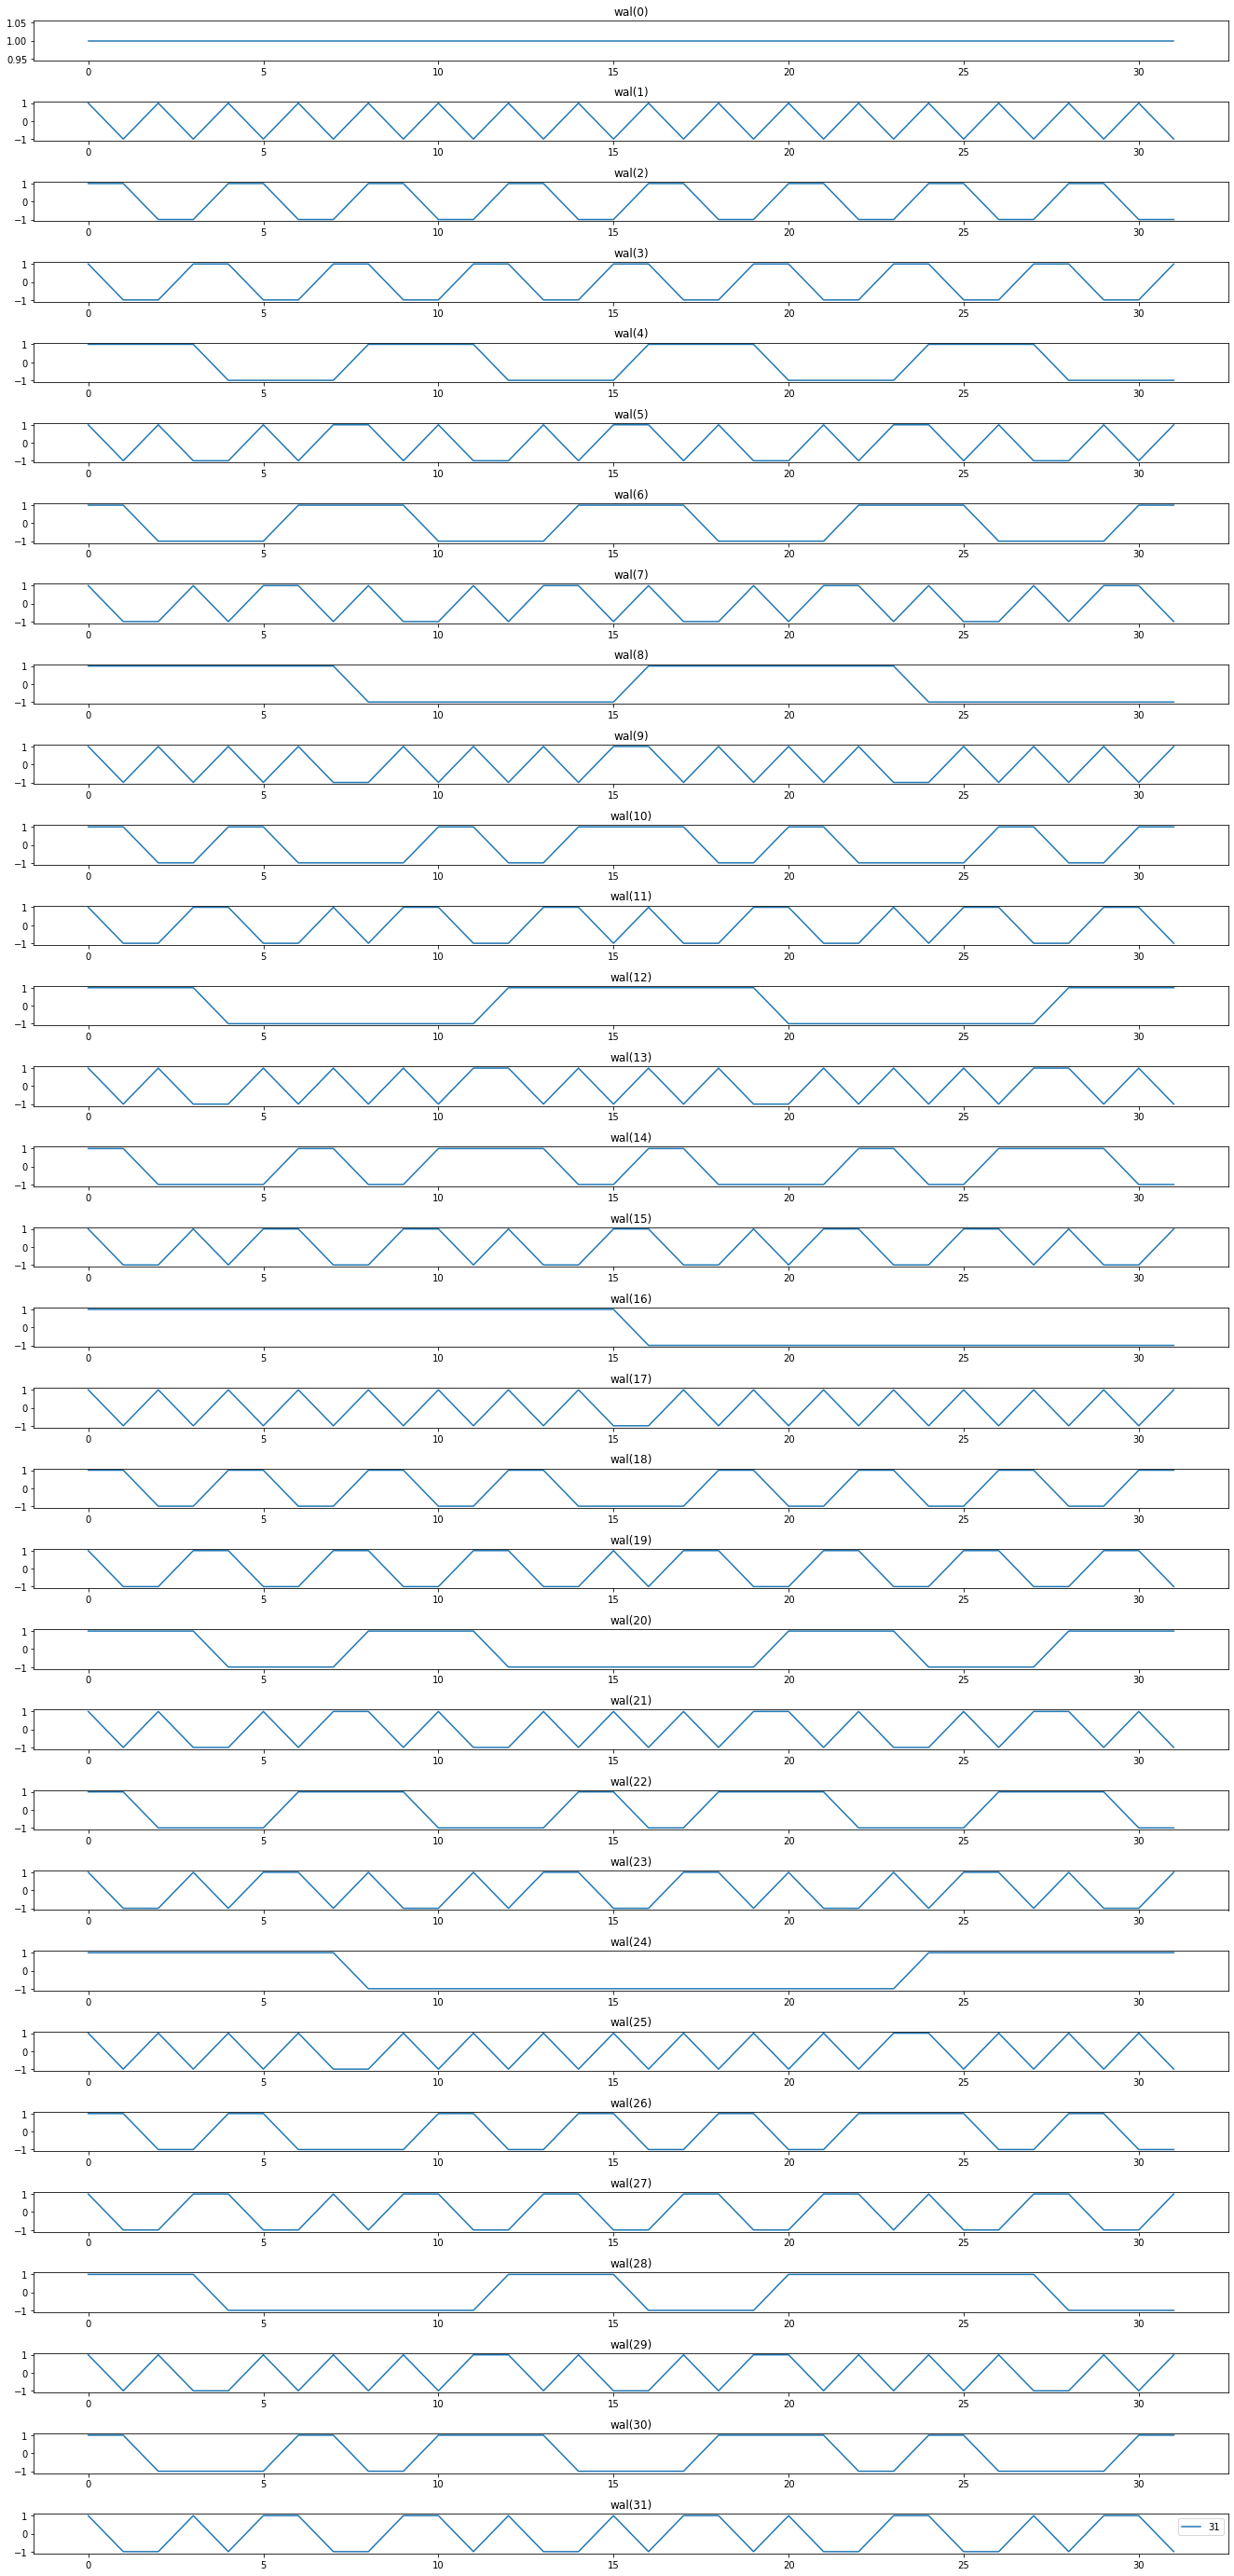

In [5]:
#Generate walsh patterns of a length 8, which could be used for 8 seperate time streams
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)
for i in range(32):
    ax[i].plot(walsh_matrix[i], label=i)
    ax[i].set_title('wal('+str(i)+')')
plt.legend()
plt.tight_layout()
plt.show()

oversample the functions by 100 

In [6]:
#extend the number of samples for the walsh function to match the signal length 
print(walsh_matrix.shape)
period_base = 100
walshextended = np.zeros((32,3200))
print(walshextended.shape)
for i in range(32):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(walsh_matrix[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

(32, 32)
(32, 3200)


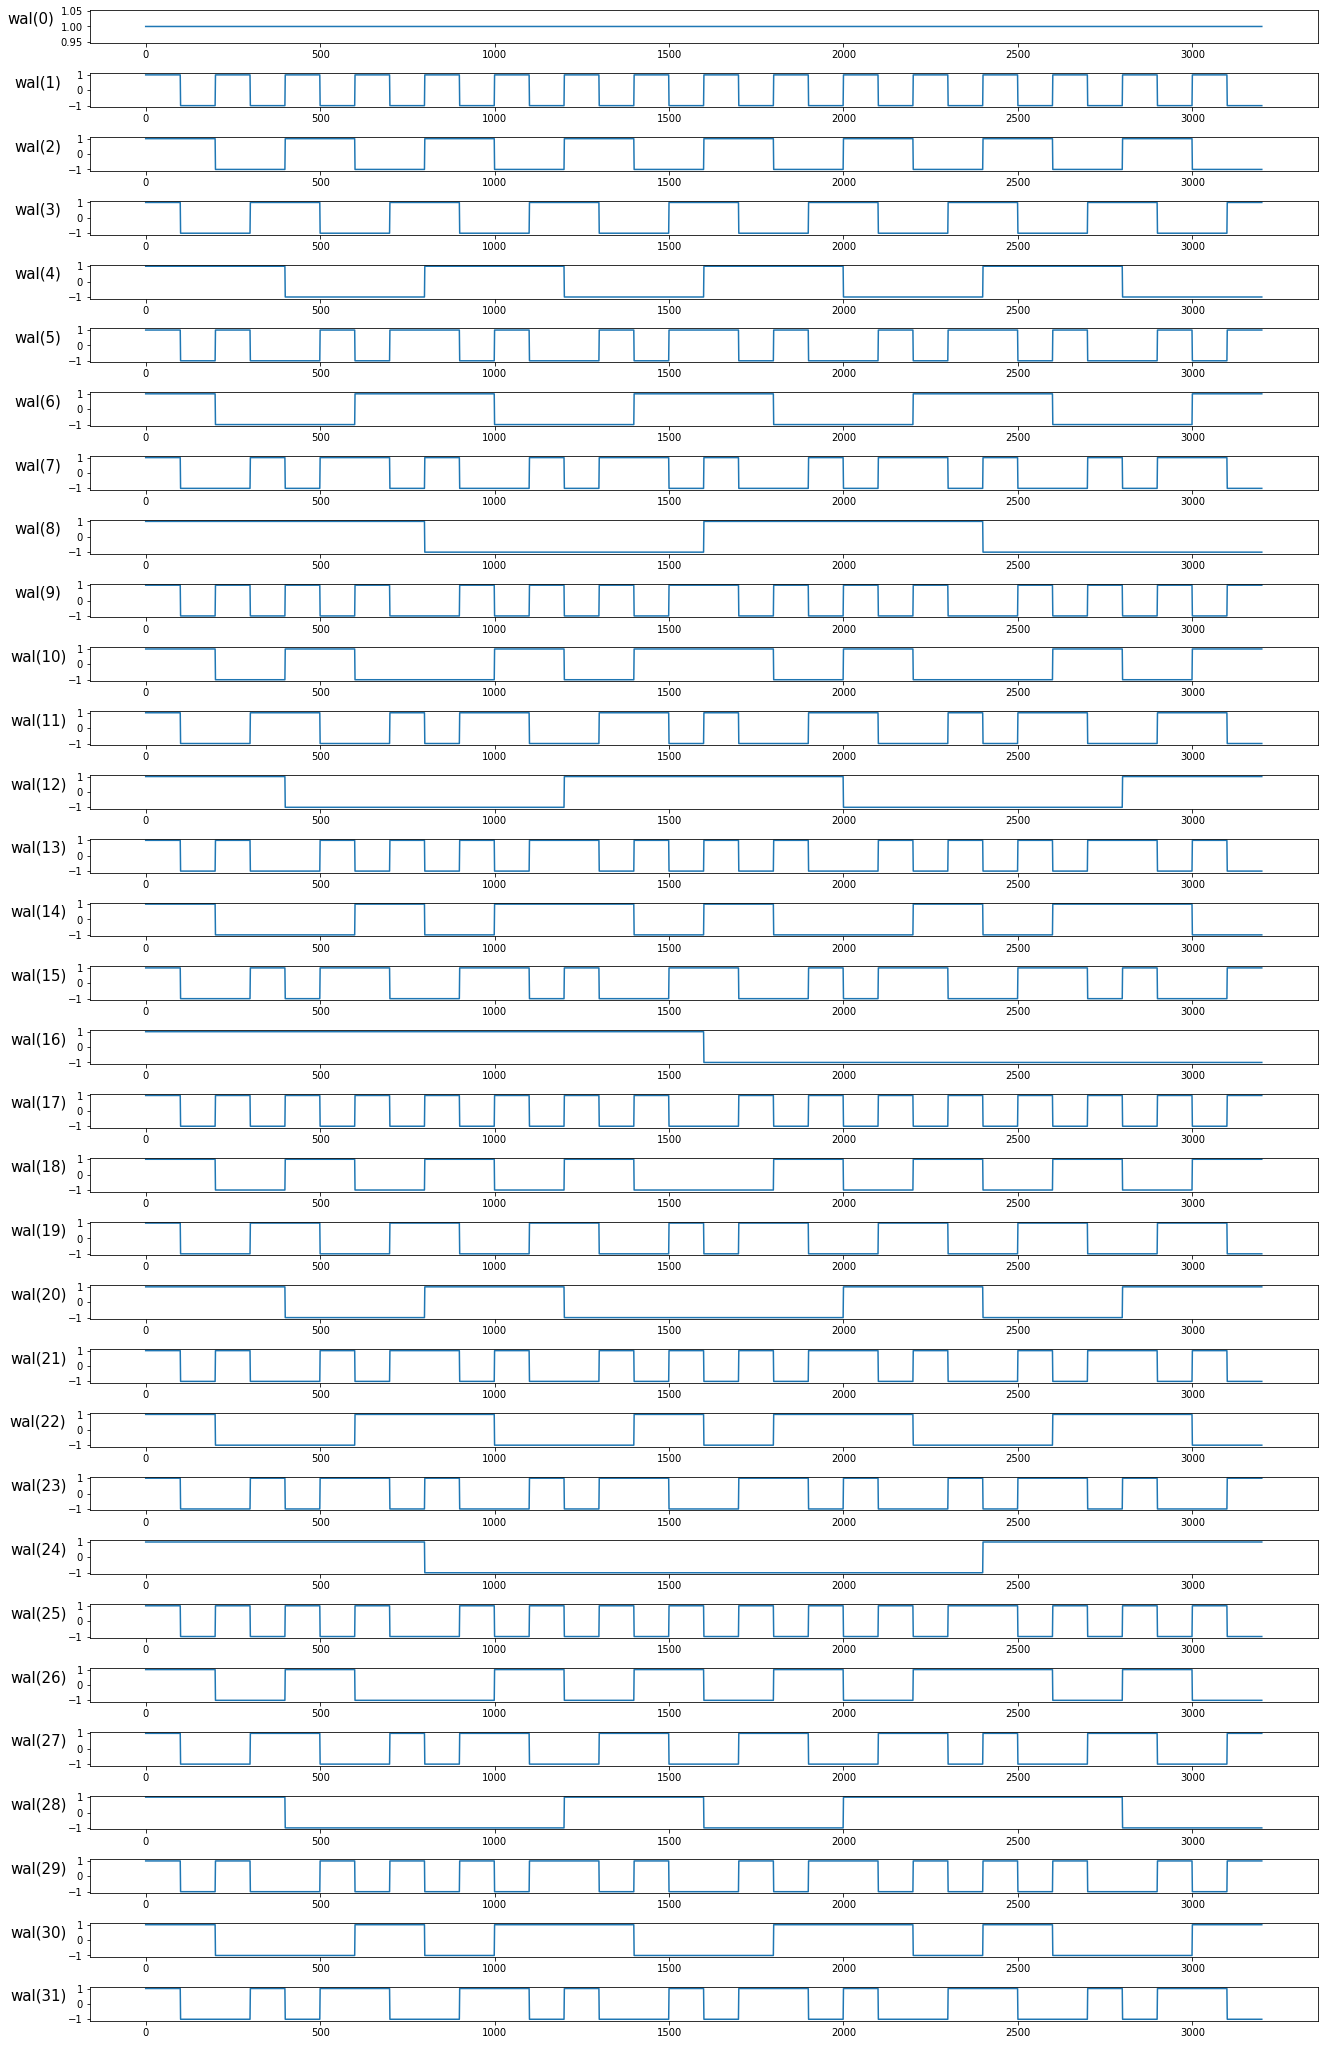

In [7]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 28.5)
for i in range(32):
    ax[i].plot(walshextended[i])
    #ax[i].set_title('wal('+str(i)+')')
    ax[i].set_ylabel('wal('+str(i)+')', rotation=0, labelpad=30, fontsize=15)
plt.tight_layout()
plt.savefig('walsh_first_32.pdf',format='pdf')
plt.show()

reorder by number of zero crossings

In [8]:
sequency = {}
for i in range(32):
    wal_ind = ((walshextended[i][:-1] * walshextended[i][1:]) < 0).sum()
    sequency[wal_ind] = walshextended[i]
    
    
sorted_walsh = [sequency[key] for key in sorted(sequency)]

sorted_inds = []
for i in range(32):
    wal_ind = ((sorted_walsh[i][:-1] * sorted_walsh[i][1:]) < 0).sum()
    sorted_inds.append(wal_ind)

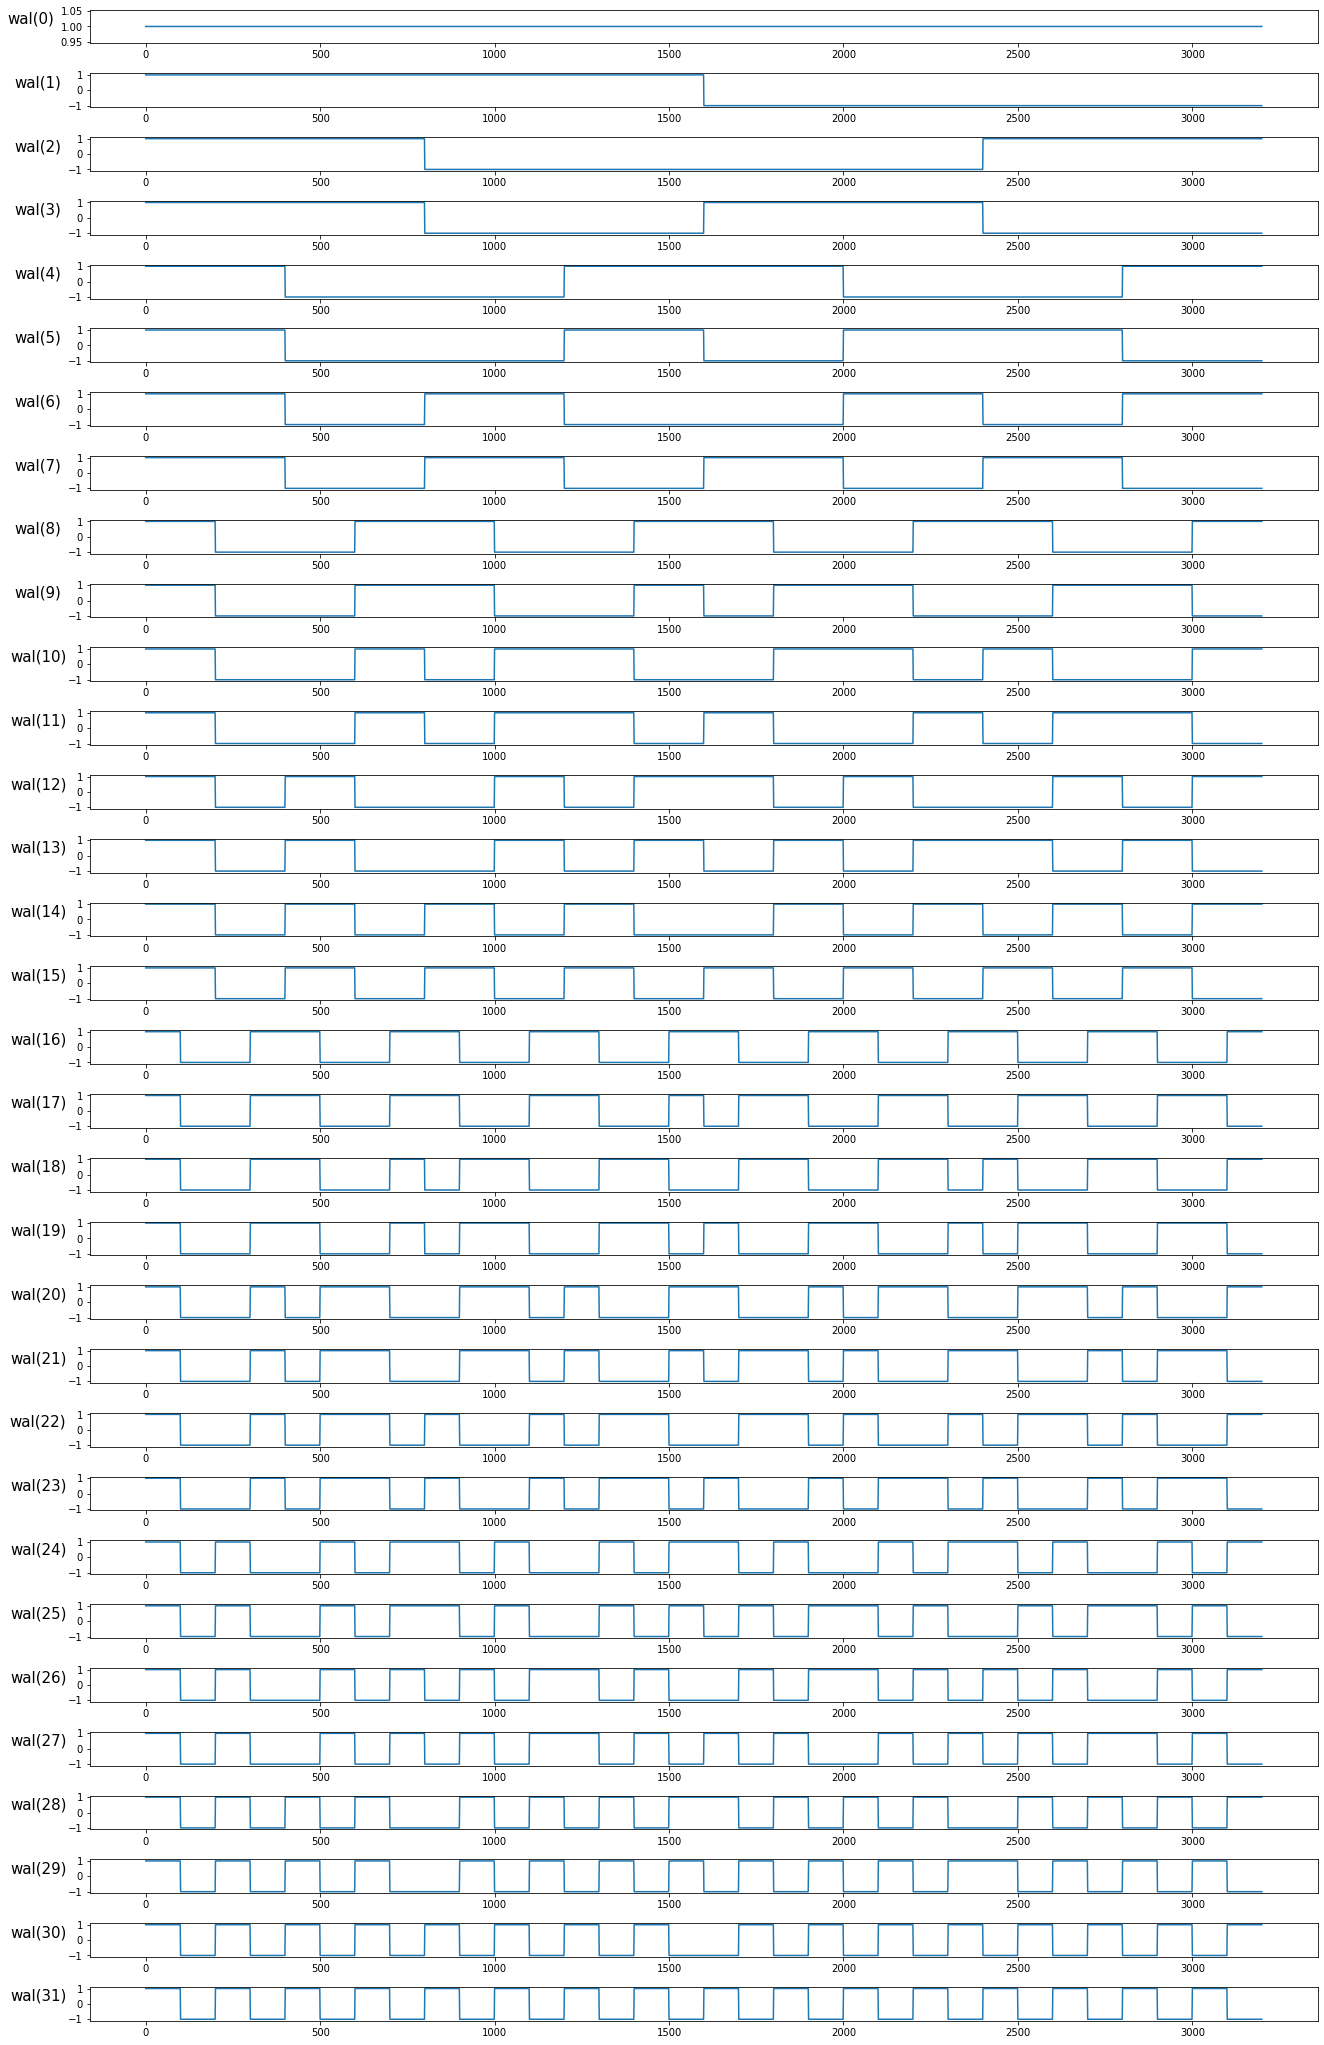

In [9]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 28.5)
for i in range(32):
    ax[i].plot(sorted_walsh[i])
    ax[i].set_ylabel('wal('+str(i)+')', rotation=0, labelpad=30, fontsize=15)

plt.tight_layout()
plt.savefig('walsh_first_32_sequency.pdf',format='pdf')

copy the signal so we can time shift 

In [10]:
copy = sorted_walsh 
doubled = np.concatenate((sorted_walsh, copy), axis=1)
print(doubled.shape)

(32, 6400)


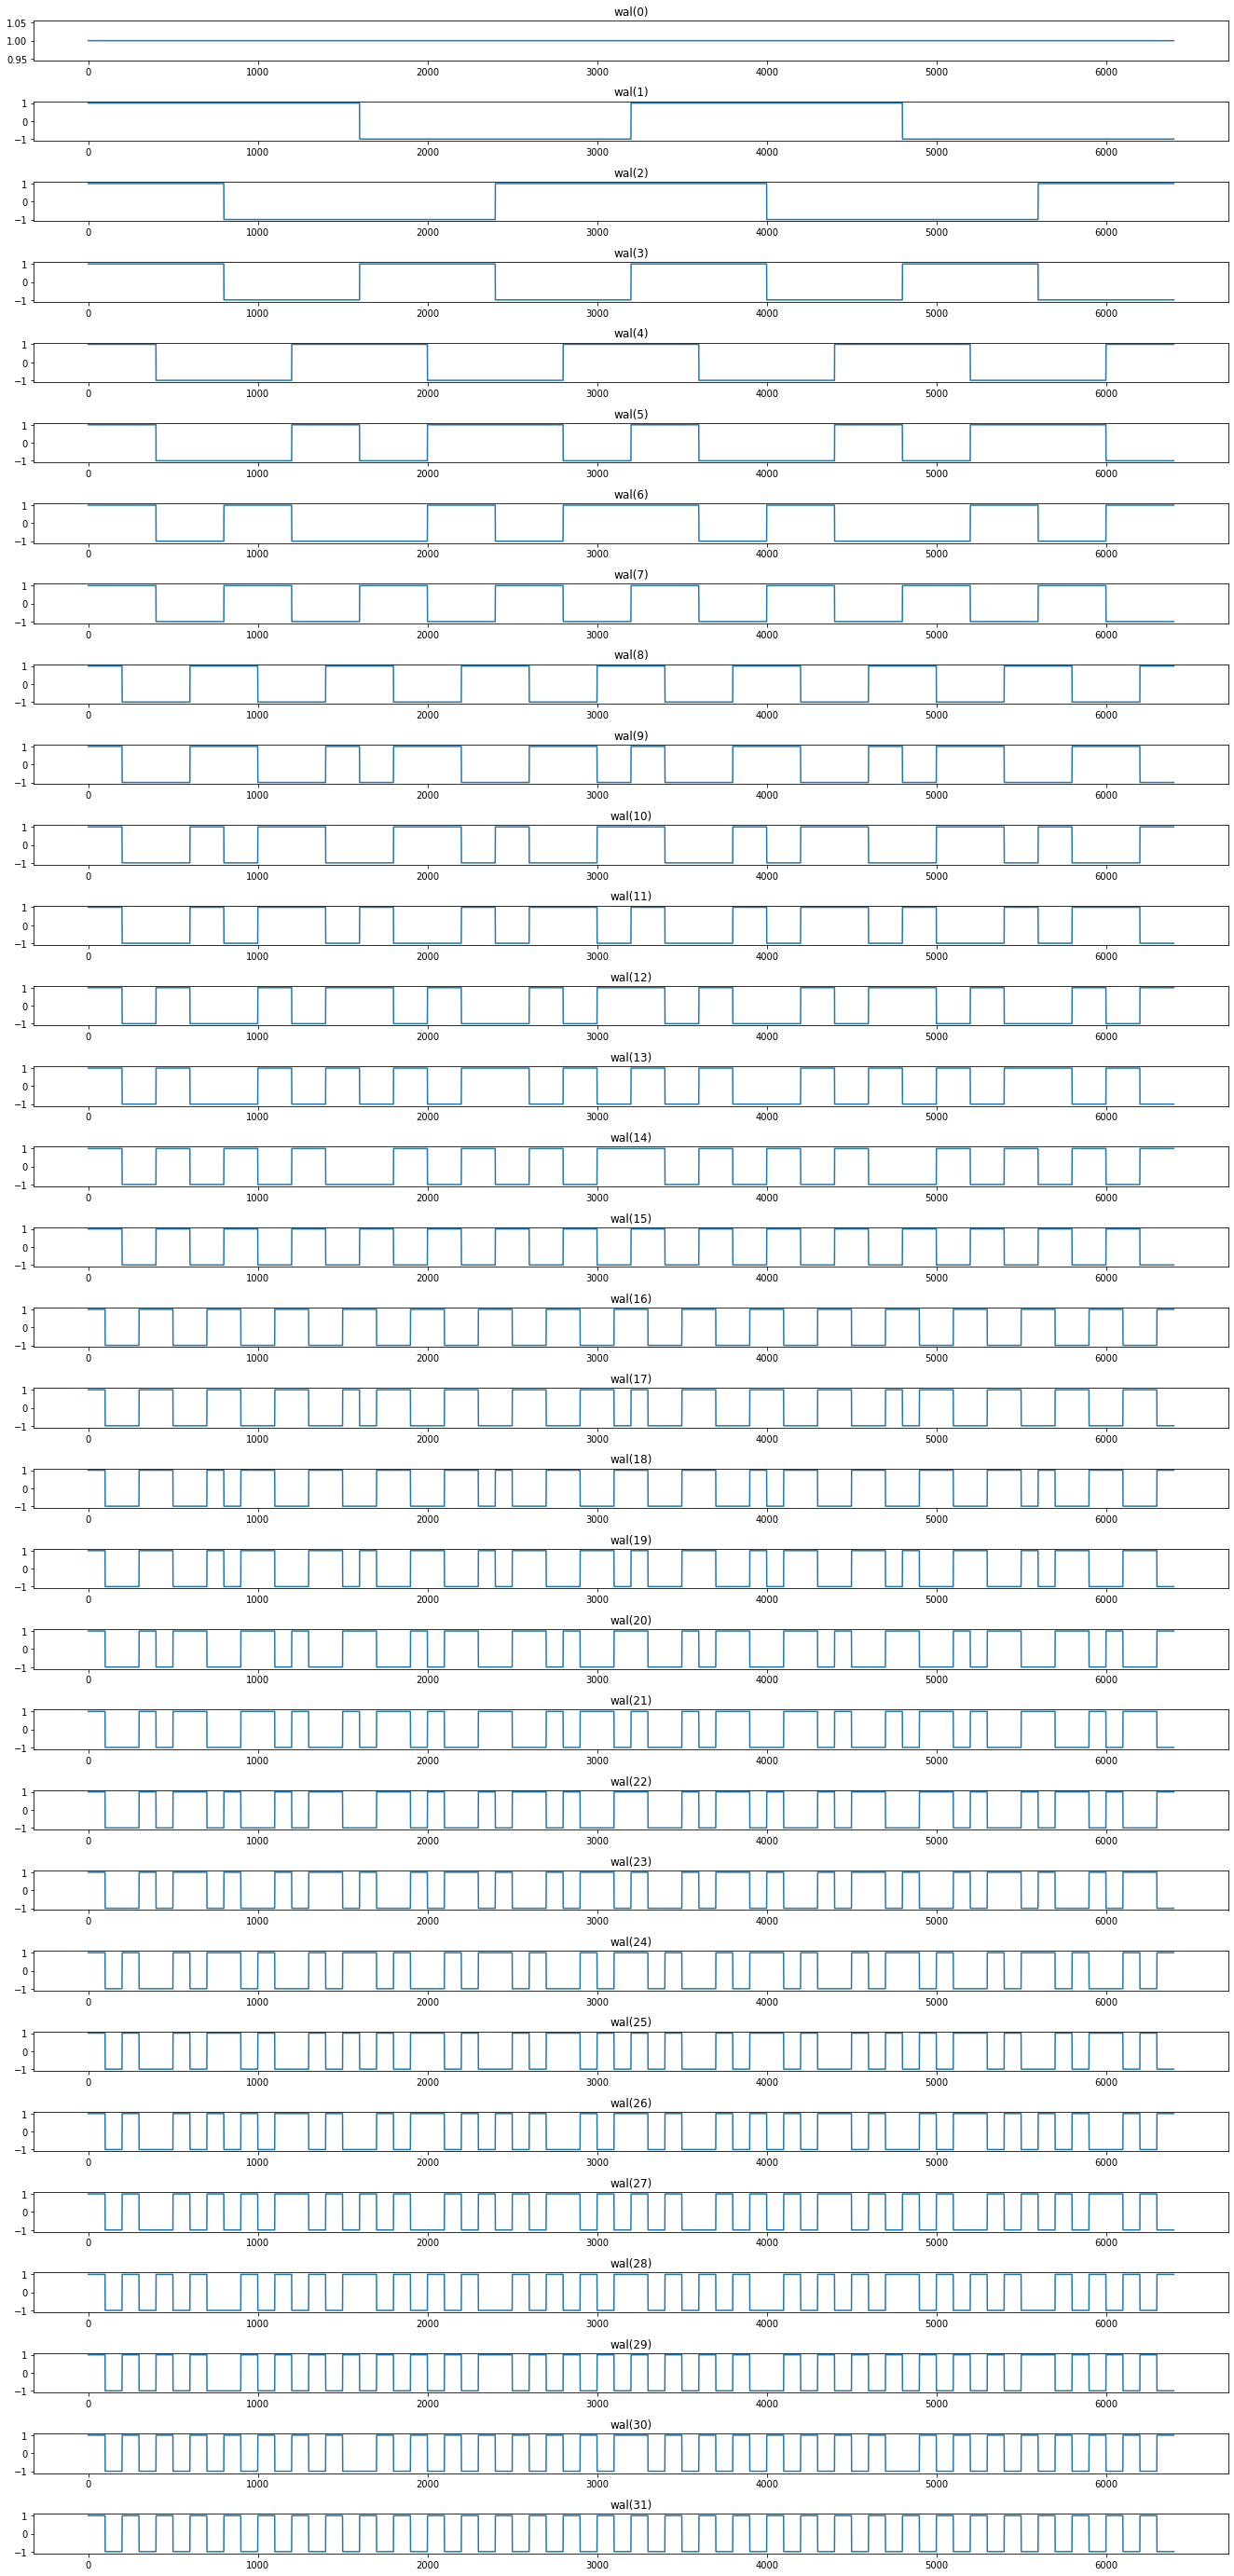

In [11]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)
for i in range(32):
    ax[i].plot(doubled[i])
    ax[i].set_title('wal('+str(i)+')')
plt.tight_layout()
plt.show()

reorder by number of zero crossings

shift by 1% of the shortest element (1), cross correlate, integrate over T

In [12]:
np.set_printoptions(threshold=np.inf)
crosstalk = np.zeros((32,32))
for i in range(32):
    shifted = doubled[i][1:3201]
    for j in range(32):
        stable = doubled[j][0:3200]
        crossprod = shifted*stable 
        resid = np.sum(crossprod)
        crosstalk[i,j] = resid/3200

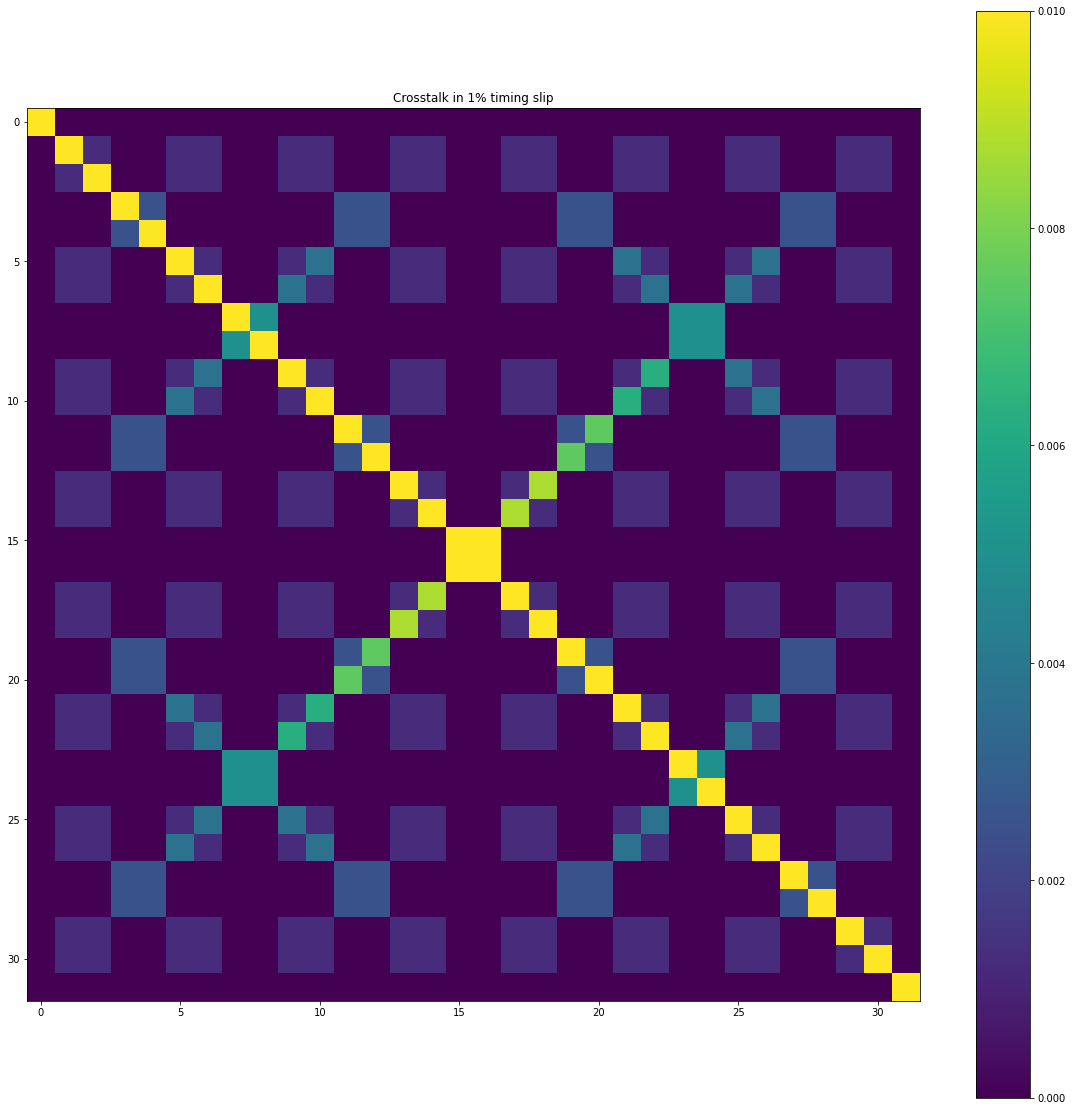

In [13]:
plt.figure(figsize=(20,20))
fig.set_size_inches(18.5, 10.5)
plt.imshow(abs(crosstalk),vmax=.01)
plt.title('Crosstalk in 1% timing slip')
plt.colorbar()
fig.set_size_inches(18.5, 18.5)
plt.savefig('crosstalk_matrix', format='pdf')

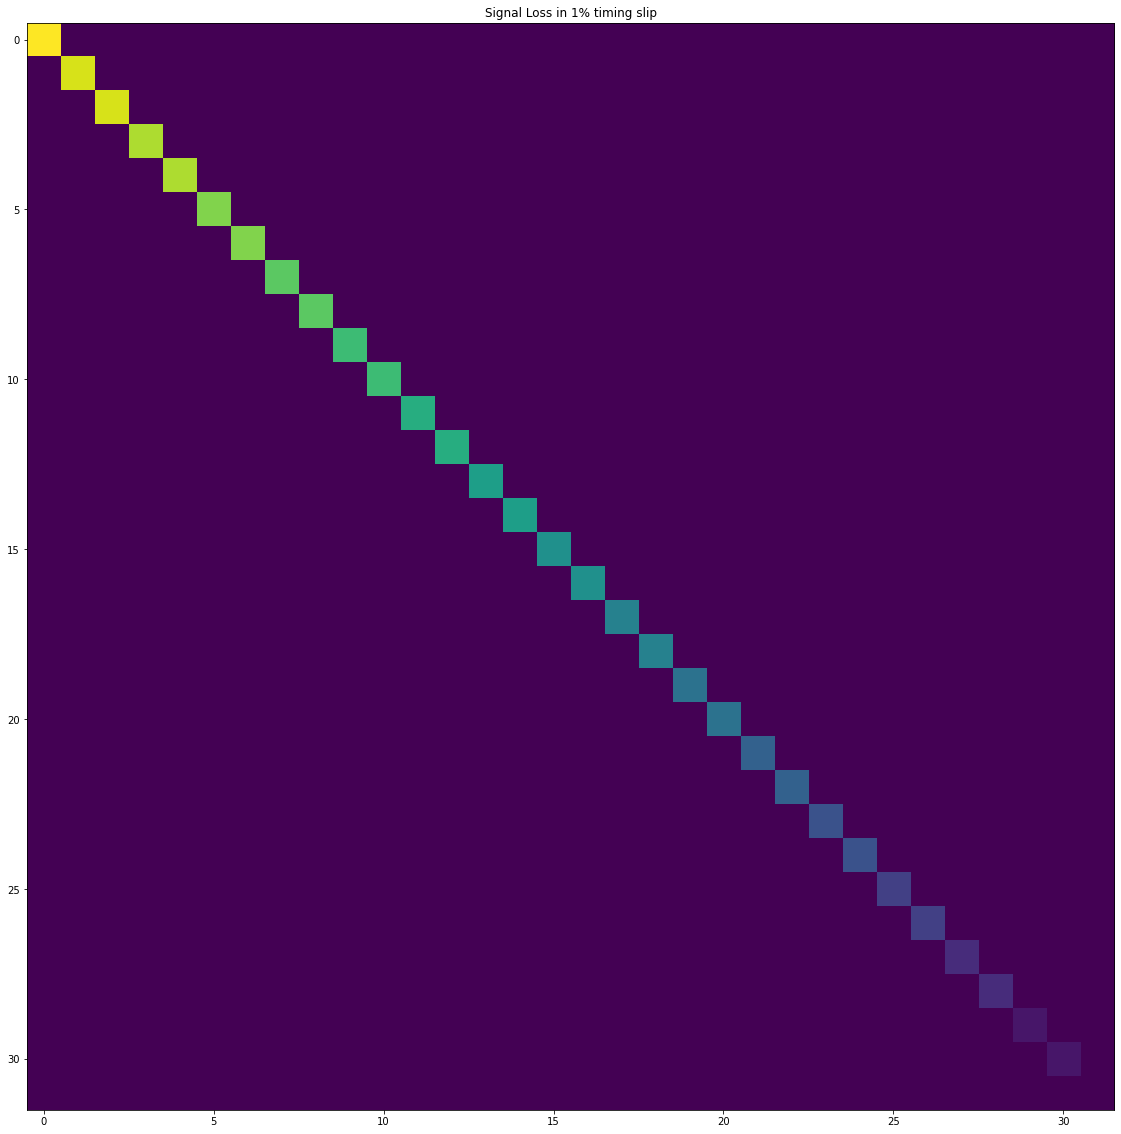

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(crosstalk,vmin=.98)
plt.title('Signal Loss in 1% timing slip')
fig.set_size_inches(18.5, 18.5)

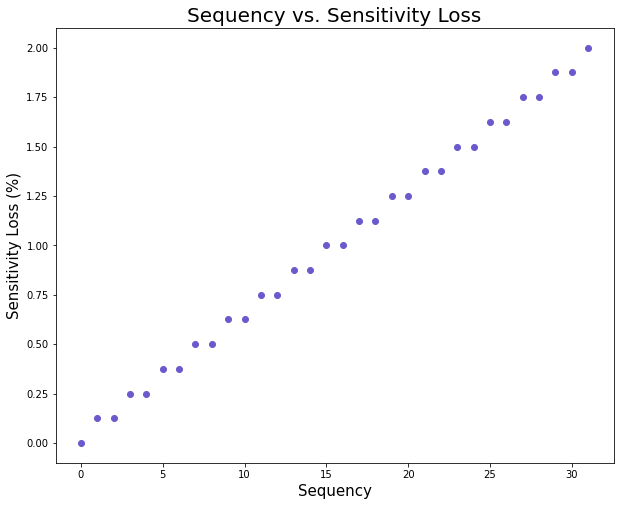

In [15]:
plt.figure(figsize=(10,8))
for i in range(32):
    for j in range(32):
        if i==j:
            plt.title('Sequency vs. Sensitivity Loss',fontsize=20)
            plt.scatter(sorted_inds[i],((1-crosstalk[i][j])*100), c='slateblue')
            plt.xlabel('Sequency',fontsize=15)
            plt.ylabel('Sensitivity Loss (%)', fontsize=15)
plt.savefig('Sensitivity_loss.pdf',format='pdf')

In [16]:
#RSS Crosstalk
rss = []
for i in range(32):
    summed = 0 
    for j in range(32):
        if i==j:
            pass
        else:
            summed += (crosstalk[i][j])**2
    rss.append(np.sqrt(summed)*100)

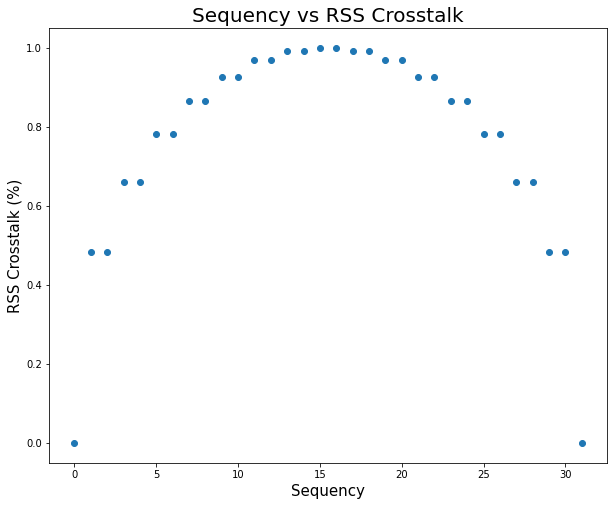

In [17]:
plt.figure(figsize=(10,8))
plt.title('Sequency vs RSS Crosstalk', fontsize=20)
plt.xlabel('Sequency', fontsize=15)
plt.ylabel('RSS Crosstalk (%)', fontsize=15)
plt.scatter(sorted_inds,rss)
plt.savefig('rsscrosstalk.pdf',format='pdf')

# What if the phase switch has an amplitude imbalance?

Instead of 1, -1, assume a 1% amplitude loss along the 180 degree path. no time shift. 

In [18]:
imbalanced_walsh = np.zeros_like(doubled)

for i in range(32):
    for j in range(len(imbalanced_walsh[i])):
        if doubled[i][j] == 1:
            imbalanced_walsh[i][j] = 1
        if doubled[i][j] == -1:
            imbalanced_walsh[i][j] = -.99

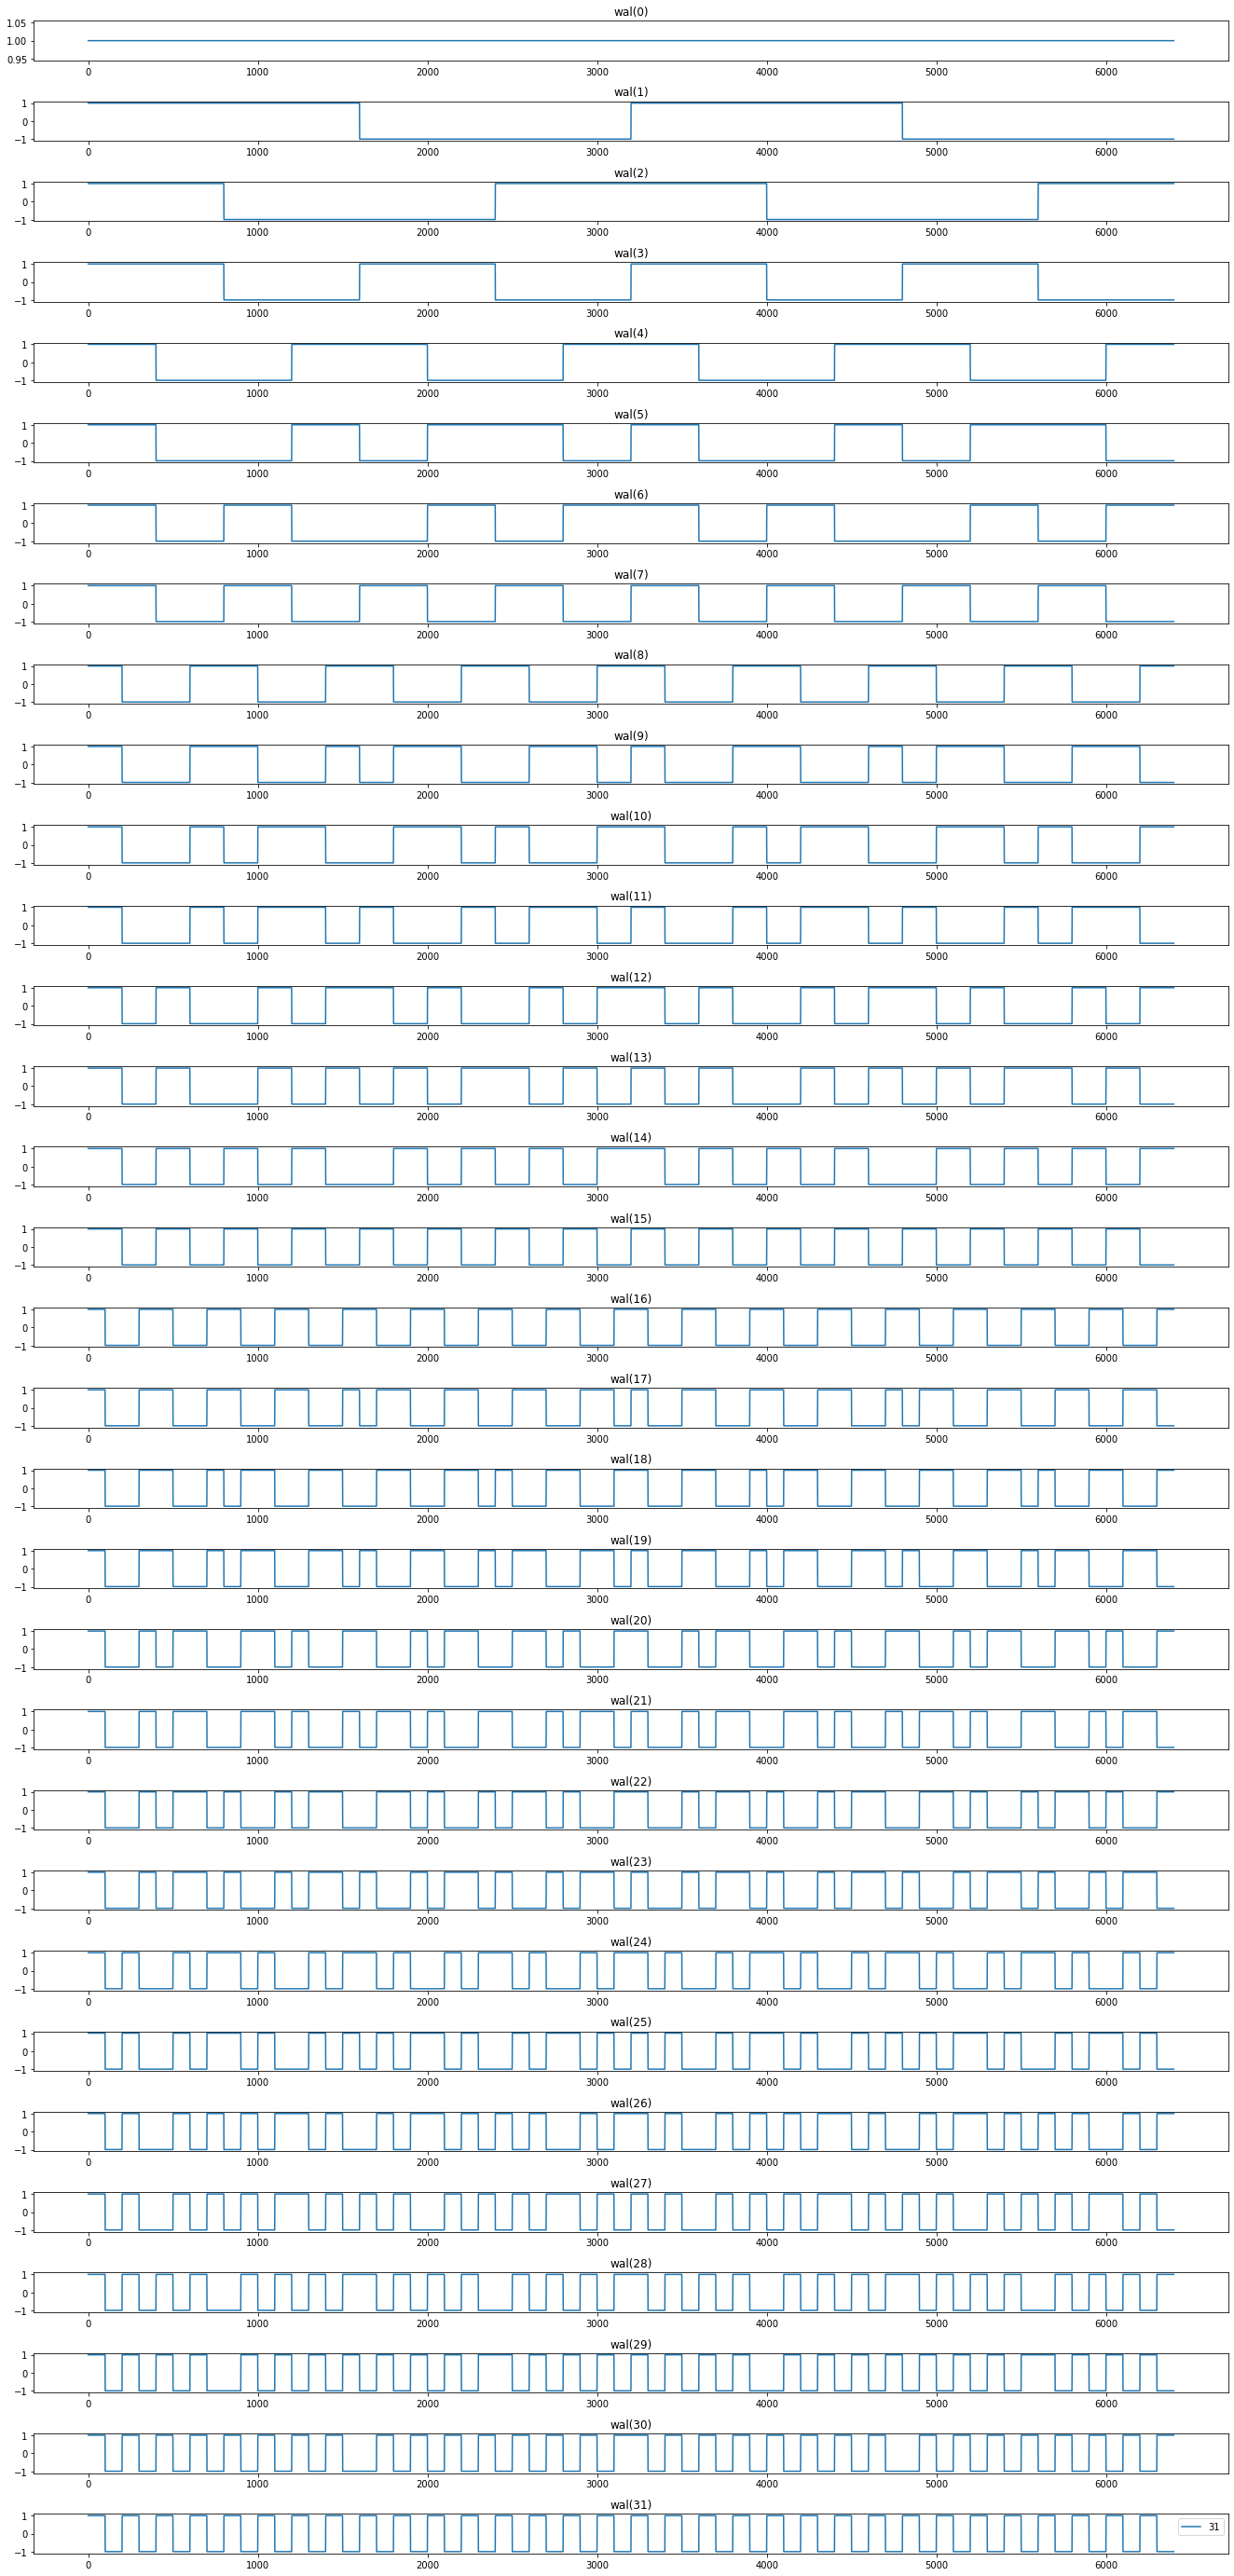

In [19]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)
for i in range(32):
    ax[i].plot(imbalanced_walsh[i], label=i)
    ax[i].set_title('wal('+str(sorted_inds[i])+')')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
crosstalkimb = np.zeros((32,32))
for i in range(32):
    shifted = imbalanced_walsh[i][0:3200]
    for j in range(32):
        stable = doubled[j][0:3200]
        crossprod = shifted*stable 
        resid = np.sum(crossprod)
        crosstalkimb[i,j] = resid/3200

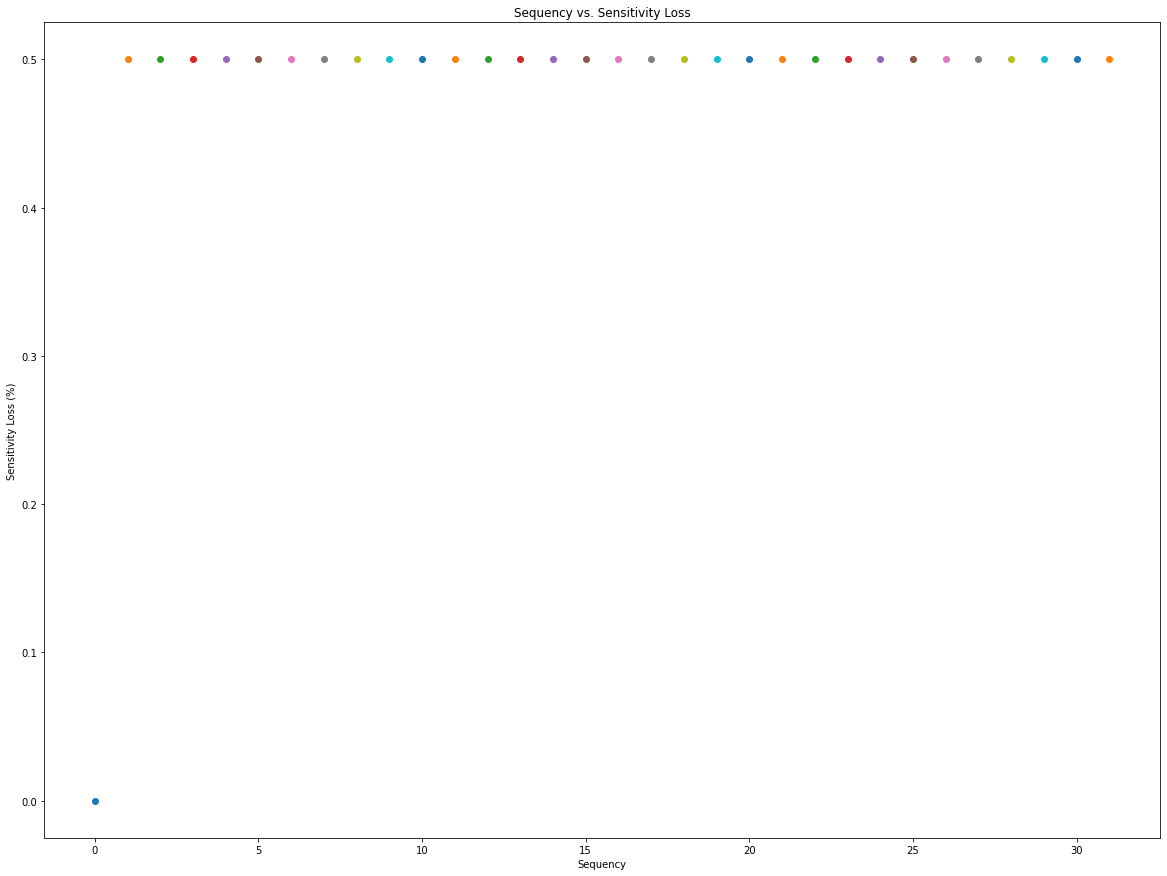

In [21]:
plt.figure(figsize=(20,15))
for i in range(32):
    for j in range(32):
        if i==j:
            plt.title('Sequency vs. Sensitivity Loss')
            plt.scatter(sorted_inds[i],((1-crosstalkimb[i][j])*100))
            plt.xlabel('Sequency')
            plt.ylabel('Sensitivity Loss (%)')

In [22]:
#RSS Crosstalk
rssimb = []
for i in range(32):
    summed = 0 
    for j in range(32):
        if i==j:
            pass
        else:
            summed += (crosstalkimb[i][j])**2
    rssimb.append(np.sqrt(summed)*100)

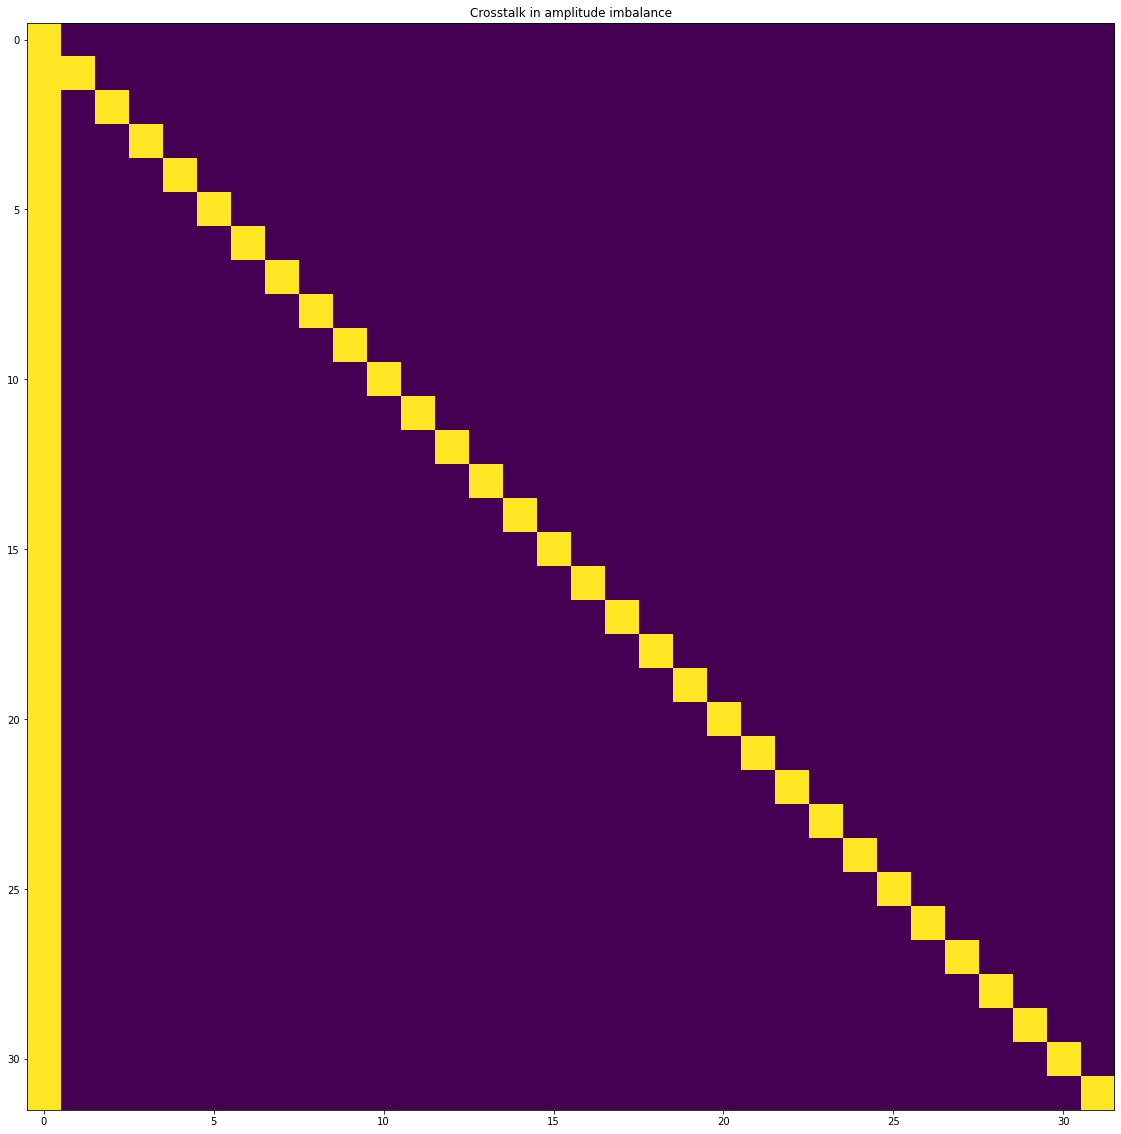

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(crosstalkimb,  vmax=.001)
plt.title('Crosstalk in amplitude imbalance')
fig.set_size_inches(18.5, 18.5)

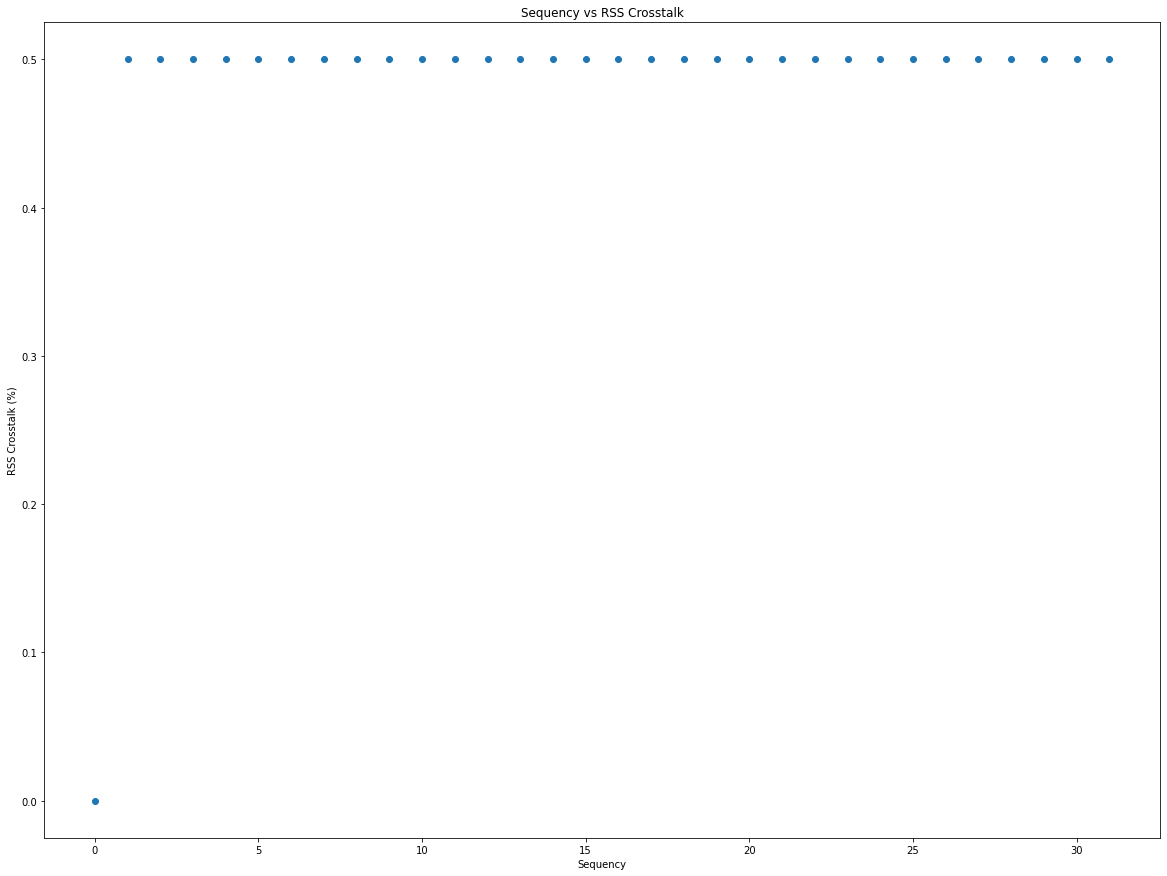

In [24]:
plt.figure(figsize=(20,15))
plt.title('Sequency vs RSS Crosstalk')
plt.xlabel('Sequency')
plt.ylabel('RSS Crosstalk (%)')
plt.scatter(sorted_inds,rssimb)

# How about a varying signal?


Try to replicate ALMA memo 565 appendix

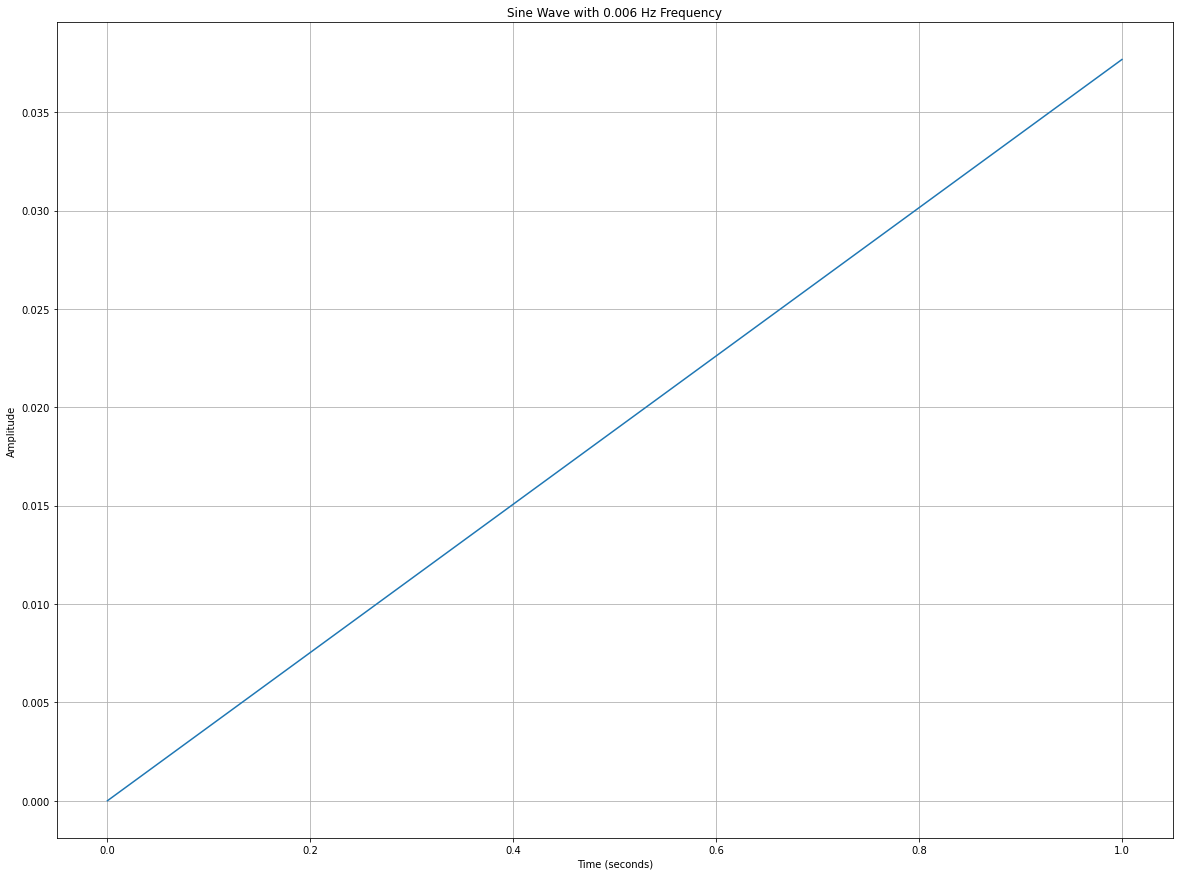

In [25]:
# Set the parameters
frequency = 0.006  # Frequency of the sine wave in Hz
duration = 1  # Duration of the signal in seconds
sampling_rate = 3200  # Sampling rate in Hz

t = np.arange(0, duration, 1/sampling_rate)

# Generate the sine wave
sine_wave = np.sin(2 * np.pi * frequency * t)

plt.figure(figsize=(20,15))
plt.plot(t, sine_wave)
plt.title(f"Sine Wave with {frequency} Hz Frequency")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

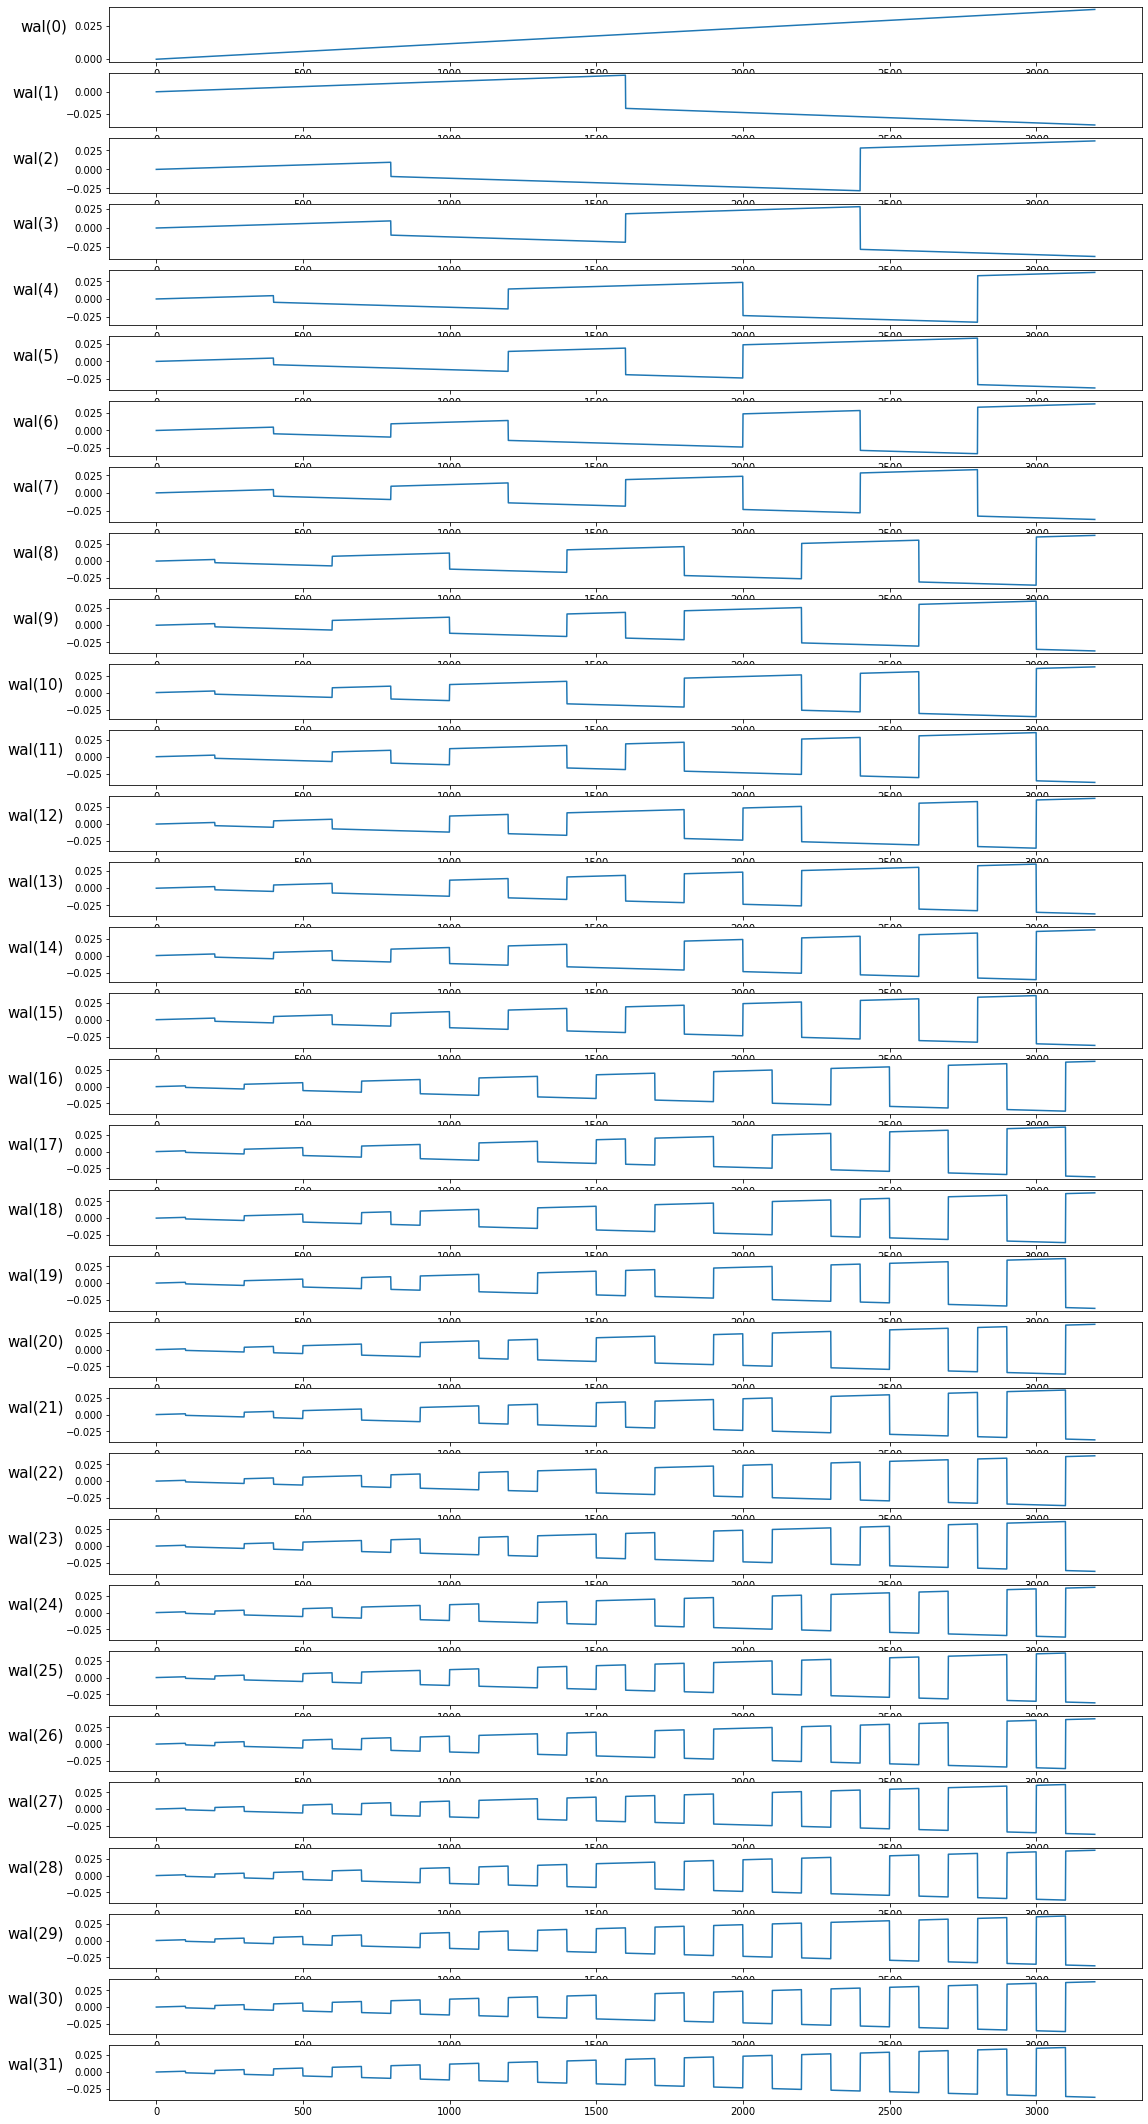

In [26]:
fig,ax = plt.subplots(32,1)
fig.set_size_inches(18.5, 38.5)

for i in range(32):
    mod = sine_wave*doubled[i][0:3200]
    ax[i].plot(mod)
    ax[i].set_ylabel('wal('+str(i)+')', rotation=0, labelpad=30, fontsize=15)

    
plt.tight_layout 
plt.show()

In [27]:
crosstalk_single = []
for i in range(32):
    crosstalk = np.sum(sine_wave*doubled[i][0:3200])
    normed = crosstalk/3200
    crosstalk_single.append(normed)

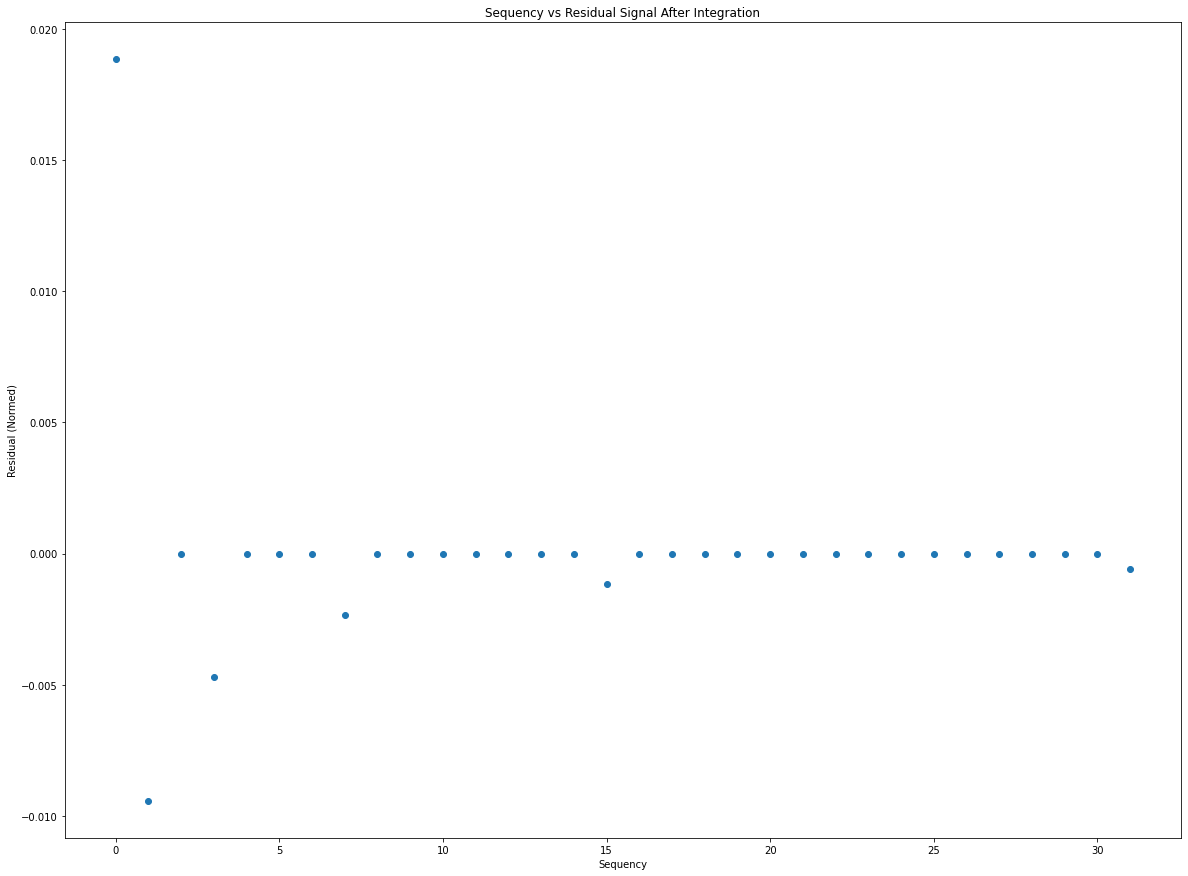

In [28]:
plt.figure(figsize=(20,15))
plt.title('Sequency vs Residual Signal After Integration')
plt.xlabel('Sequency')
plt.ylabel('Residual (Normed)')
plt.scatter(sorted_inds, crosstalk_single)

In [29]:
crosstalk = np.zeros((32,32))
for i in range(32):
    for j in range(32):
        mult1 = doubled[i][0:3200]*sine_wave
        mult2 = doubled[j][0:3200]*sine_wave
        crossprod = mult1*mult2
        resid = np.sum(crossprod)
        crosstalk[i,j] = resid/3200

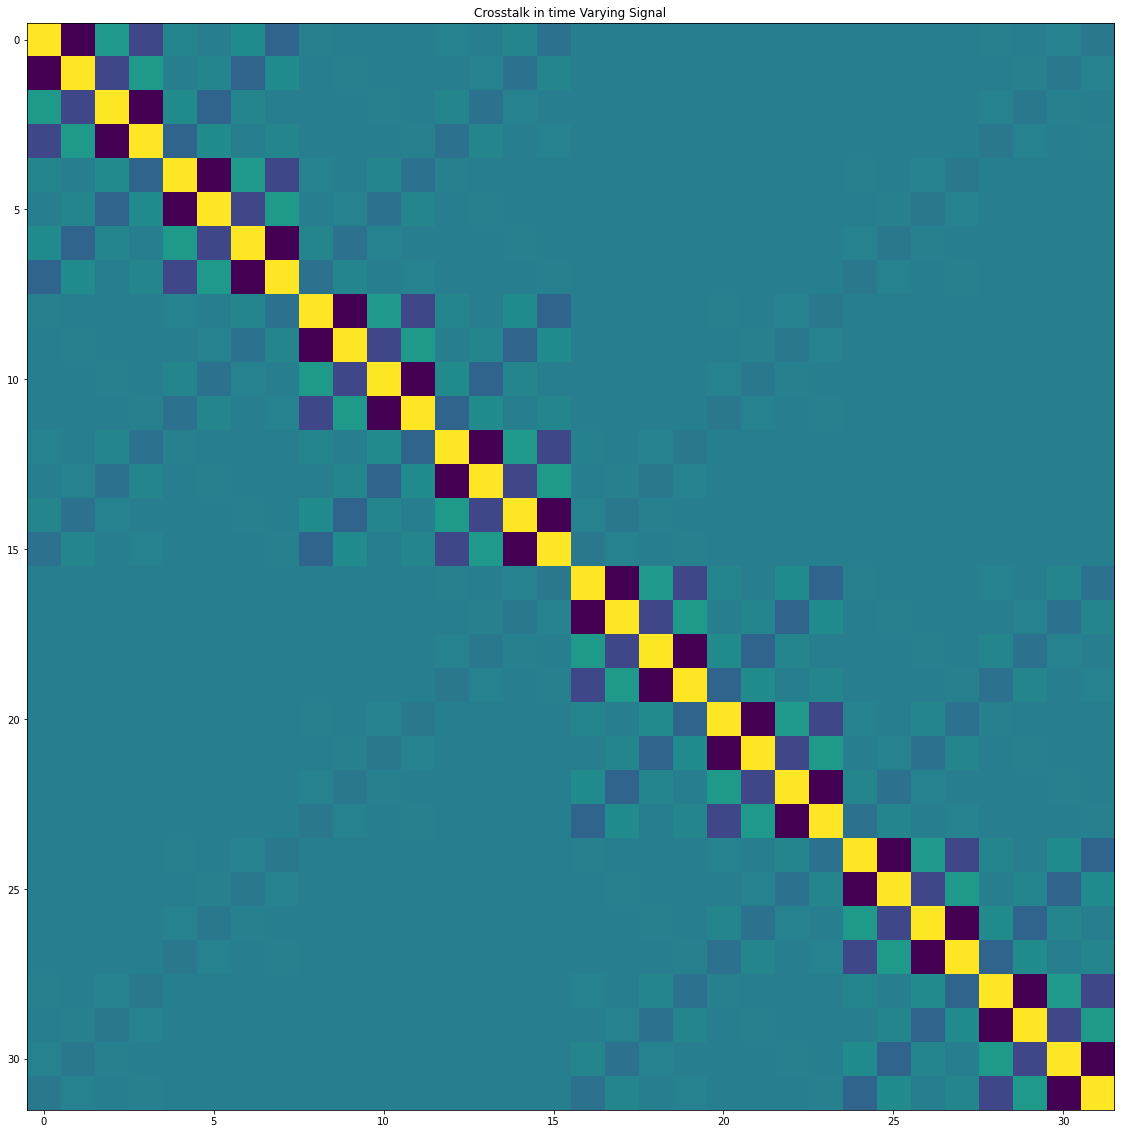

In [30]:
plt.figure(figsize=(20,20))
fig.set_size_inches(18.5, 10.5)
plt.imshow(crosstalk)
plt.title('Crosstalk in time Varying Signal')
fig.set_size_inches(18.5, 18.5)

In [31]:
rss = []
for i in range(32):
    summed = 0 
    for j in range(32):
        if i==j:
            pass
        else:
            summed += (crosstalk[i][j])**2
    rss.append(np.sqrt(summed)*100)

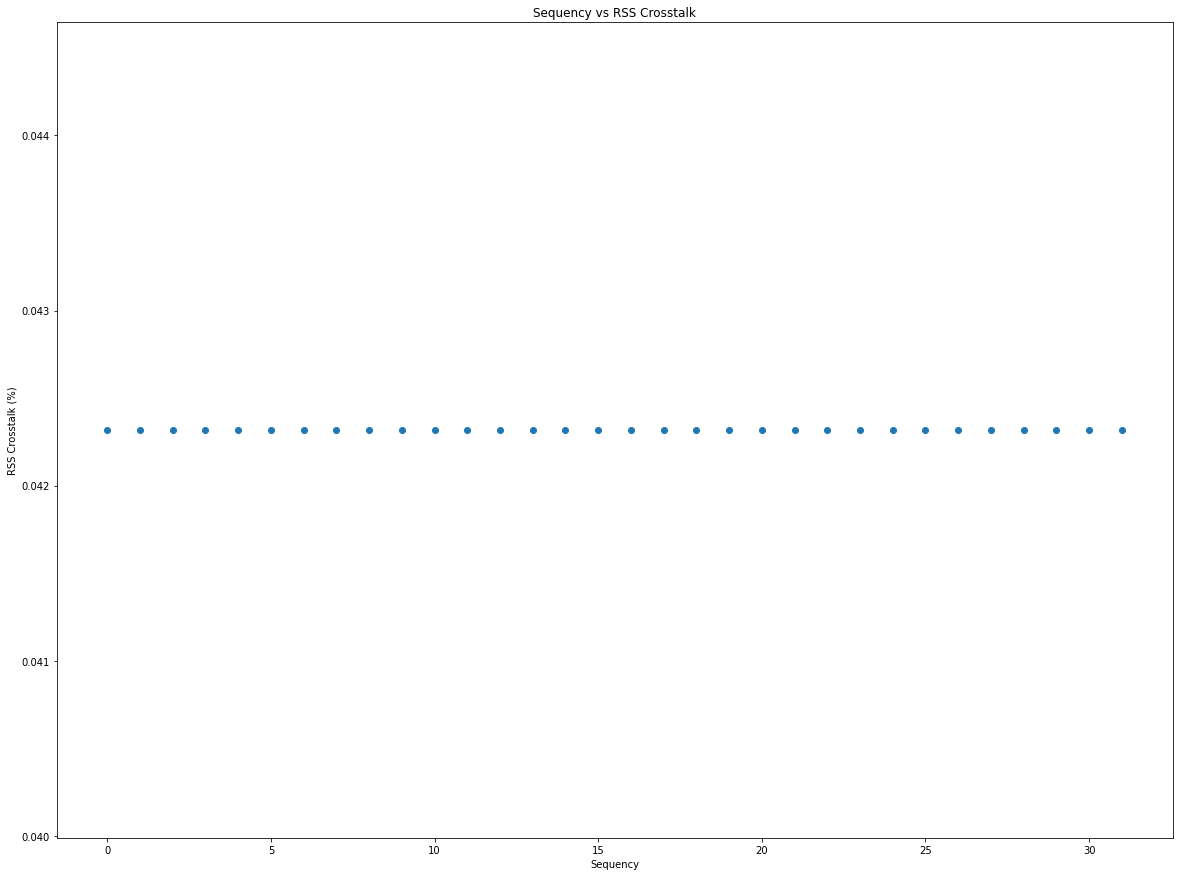

In [32]:
plt.figure(figsize=(20,15))
plt.title('Sequency vs RSS Crosstalk')
plt.xlabel('Sequency')
plt.ylabel('RSS Crosstalk (%)')
plt.scatter(sorted_inds,rss)

Try to loop through frequencies 

In [33]:
# Set the parameters
nfreqs = 50 
freqs = np.linspace(0,2,nfreqs)
sigs = []
cross_freq = []


for freq in freqs: 
    i = 0 
    
    frequency = freq  # Frequency of the sine wave in Hz
    duration = 1  # Duration of the signal in seconds
    sampling_rate = 3200  # Sampling rate in Hz

    t = np.arange(0, duration, 1/sampling_rate)

    # Generate the sine wave
    sine_wave = np.sin(2 * np.pi * frequency * t)
    sigs.append(sine_wave)
    
    crosstalk = np.zeros((32,32))
    
    for i in range(32):
        for j in range(32):
            mult1 = doubled[i][0:3200]*sine_wave
            mult2 = doubled[j][0:3200]*sine_wave
            crossprod = mult1*mult2
            resid = np.sum(crossprod)
            crosstalk[i,j] = resid/3200
            
            
    rss = []
    
    for i in range(32):
        summed = 0 
        for j in range(32):
            if i==j:
                pass
            else:
                summed += (crosstalk[i][j])**2
        rss.append(np.sqrt(summed)*100)
    cross_freq.append(rss)
    i+=1


Text(0, 0.5, 'Frequency #')

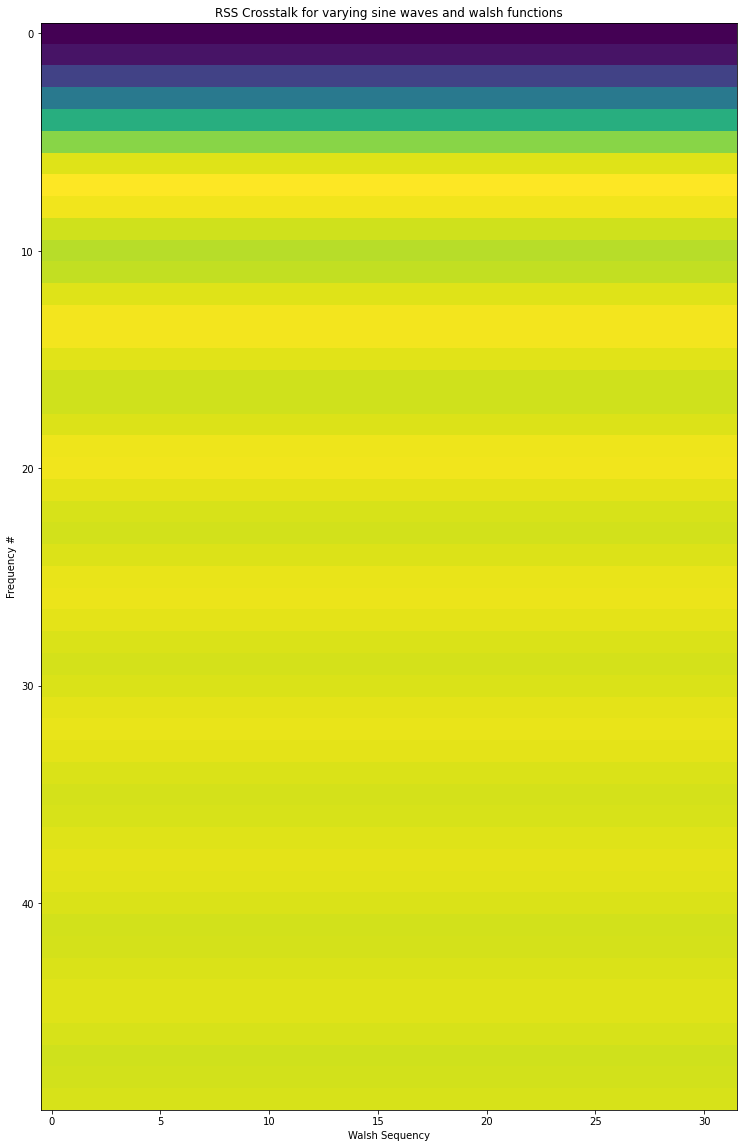

In [34]:
plt.figure(figsize=(20,20))
plt.imshow(cross_freq)
plt.title('RSS Crosstalk for varying sine waves and walsh functions')
plt.xlabel('Walsh Sequency')
plt.ylabel('Frequency #')

In [35]:
rssvfreq = [item[0] for item in cross_freq]

Text(0, 0.5, 'RSS Crosstalk')

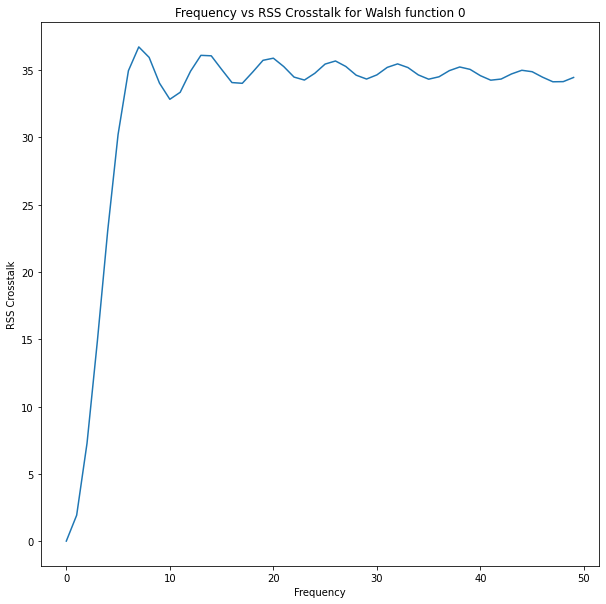

In [36]:
plt.figure(figsize=(10,10))
plt.title('Frequency vs RSS Crosstalk for Walsh function 0')
plt.plot(rssvfreq)
plt.xlabel('Frequency')
plt.ylabel('RSS Crosstalk')

# Let's do a more realistic sim, with an FFT and HERA bandwidths

In [37]:
import numpy as np

def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

def pfb_spectrometer_no_pow(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = x_pfb
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

# What does white noise look like?

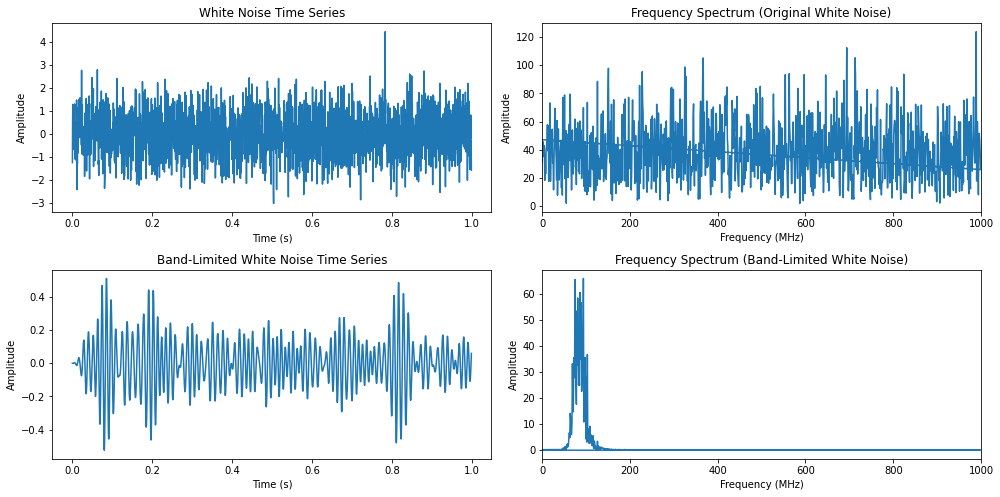

In [38]:
from scipy.signal import butter, lfilter
from numpy.fft import fft, fftfreq

# Parameters
sample_rate = 2000  # Sampling rate in MHz
duration = 1.0  # Duration in seconds
freq_range = (70, 100)  # Frequency range in MHz

# Generate time vector
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

# Generate white noise
white_noise = np.random.normal(0, 1, len(t))

# Design a bandpass filter
nyquist = 0.5 * sample_rate
low = freq_range[0] / nyquist
high = freq_range[1] / nyquist
b, a = butter(4, [low, high], btype='band')


band_limited_noise = lfilter(b, a, white_noise)

# Compute FFT for the original white noise
fft_white_noise = fft(white_noise)
freqs_white_noise = fftfreq(len(t), 1 / sample_rate)

# Compute FFT for the band-limited white noise
fft_band_limited_noise = fft(band_limited_noise)
freqs_band_limited_noise = fftfreq(len(t), 1 / sample_rate)

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
plt.plot(t, white_noise)
plt.title('White Noise Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 2, 2)
plt.plot(freqs_white_noise, np.abs(fft_white_noise))
plt.title('Frequency Spectrum (Original White Noise)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.xlim(0, sample_rate / 2)

plt.subplot(3, 2, 3)
plt.plot(t, band_limited_noise)
plt.title('Band-Limited White Noise Time Series')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(3, 2, 4)
plt.plot(freqs_band_limited_noise, np.abs(fft_band_limited_noise))
plt.title('Frequency Spectrum (Band-Limited White Noise)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude')
plt.xlim(0, sample_rate / 2)

plt.tight_layout()
plt.show()

In [39]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 32     # Number of windows of length M*P in input time stream
n_int = 1          # Number of time integrations on output data


sample_rate = 500  # Sampling rate in MHz
duration = M*P*W  # Duration in seconds

# Generate time vector
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

samples = M*P*W

freq_range = (70, 100)  # Frequency range in MHz

# Generate white noise
white_noise = np.random.normal(0, 1, len(t))

# Design a bandpass filter
nyquist = 0.5 * sample_rate
low = freq_range[0] / nyquist
high = freq_range[1] / nyquist
b, a = butter(4, [low, high], btype='band')

band_limited_noise = lfilter(b, a, white_noise)

result_spectrum =  pfb_spectrometer(band_limited_noise, n_taps=M, n_chan=P, n_int=n_int, window_fn="hamming")

In [40]:
from numpy.fft import fft, rfftfreq
freqs_band_limited_noise = fftfreq(P, 1 / sample_rate)

Text(0, 0.5, 'Amplitude(dB)')

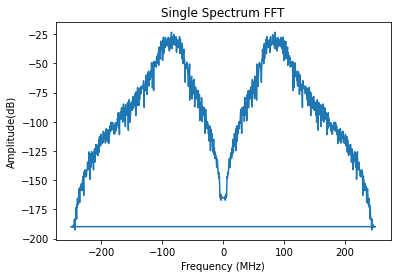

In [41]:
plt.title('Single Spectrum FFT')
plt.plot(freqs_band_limited_noise, db(result_spectrum[0]))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

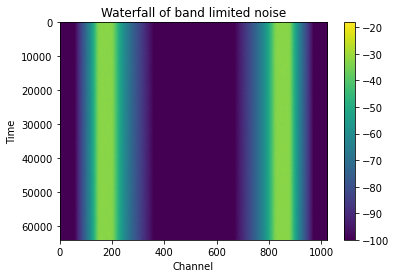

In [42]:
plt.title('Waterfall of band limited noise')
plt.imshow(db(result_spectrum), cmap='viridis', aspect='auto', vmin=-100)
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.show()

(1, 1024)


Text(0, 0.5, 'Amplitude(dB)')

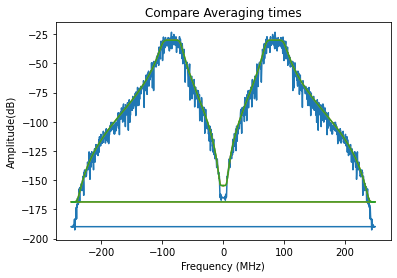

In [43]:
result_spectrum_long =  pfb_spectrometer(band_limited_noise, n_taps=M, n_chan=P, n_int=result_spectrum.shape[0], window_fn="hamming")
print(result_spectrum_long.shape)
plt.plot(freqs_band_limited_noise, db(result_spectrum[0]), label='No averaging')
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum, axis=0)), label='Averaging with Spectrometer')
plt.plot(freqs_band_limited_noise, db(result_spectrum_long[0]), label='Averaging with np.mean')

plt.title('Compare Averaging times')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

In [44]:
period_base = len(t)//32
walshextended = np.zeros((2,len(t)))
print(walshextended.shape)
for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(walsh_matrix[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

(2, 65536000)


In [207]:
def pfb_spectrometer_walsh(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    #apply walsh function 
    modulated = walshextended[0]*x
    modulated2 = walshextended[1]*x
    # Apply frontend, take FFT, then take power (i.e. square)
    
    x_fir1 = pfb_fir_frontend(modulated, win_coeffs, M, P)
    x_fir2 = pfb_fir_frontend(modulated2, win_coeffs, M, P)
    x_pfb = fft(x_fir1, P)
    x_pfb2 = np.conj(fft(x_fir2, P))
    x_psd = x_pfb*x_pfb2
    
    # Trim array so we can do time integration
    x_psd = x_pfb[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd


In [46]:
result_spectrum_walsh =  pfb_spectrometer_walsh(band_limited_noise, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Amplitude(dB)')

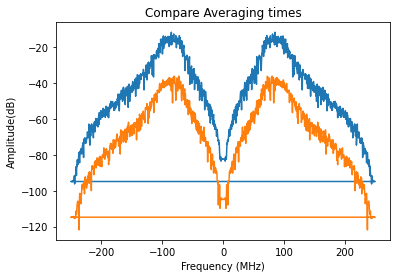

In [47]:
plt.title('Walsh function results')
plt.plot(freqs_band_limited_noise, db(result_spectrum_walsh[0]), label='Single Spectrum')
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum_walsh, axis=0)), label='Averaged over Walsh Time')
plt.title('Compare Averaging times')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

Text(0, 0.5, 'Amplitude(dB)')

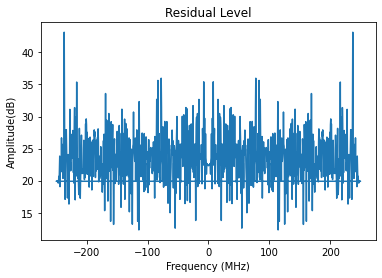

In [48]:
plt.title('Residual Level')
plt.plot(freqs_band_limited_noise, db(result_spectrum_walsh[0])- db(np.mean(result_spectrum_walsh, axis=0)))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

# Generate louder noise 

In [49]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 32     # Number of windows of length M*P in input time stream
n_int = 1          # Number of time integrations on output data


sample_rate = 500  # Sampling rate in MHz
duration = M*P*W  # Duration in seconds

# Generate time vector
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

samples = M*P*W

freq_range = (70, 100)  # Frequency range in MHz

# Generate white noise
white_noise = np.random.normal(0, 10, len(t))

# Design a bandpass filter
nyquist = 0.5 * sample_rate
low = freq_range[0] / nyquist
high = freq_range[1] / nyquist
b, a = butter(4, [low, high], btype='band')

band_limited_noise = lfilter(b, a, white_noise)

result_spectrum_loud = pfb_spectrometer_walsh(band_limited_noise, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")

Text(0, 0.5, 'Amplitude(dB)')

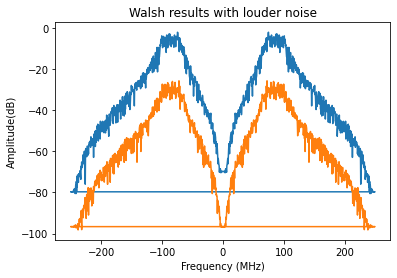

In [50]:
plt.plot(freqs_band_limited_noise, db(result_spectrum_loud[0]))
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum_loud, axis=0)))
plt.title('Walsh results with louder noise')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

Text(0, 0.5, 'Amplitude(dB)')

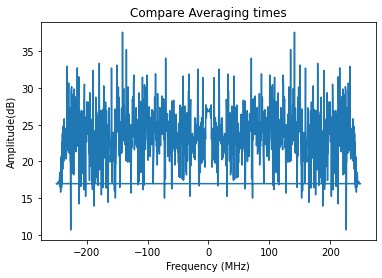

In [51]:
plt.title('Residual')
plt.plot(freqs_band_limited_noise, db(result_spectrum_loud[0])- db(np.mean(result_spectrum_loud, axis=0)))
plt.title('Compare Averaging times')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

# Even louder noise 

In [52]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 32     # Number of windows of length M*P in input time stream
n_int = 1          # Number of time integrations on output data


sample_rate = 500  # Sampling rate in MHz
duration = M*P*W  # Duration in seconds

# Generate time vector
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

samples = M*P*W

freq_range = (70, 100)  # Frequency range in MHz

# Generate white noise
white_noise = np.random.normal(0, 100, len(t))

# Design a bandpass filter
nyquist = 0.5 * sample_rate
low = freq_range[0] / nyquist
high = freq_range[1] / nyquist
b, a = butter(4, [low, high], btype='band')

band_limited_noise = lfilter(b, a, white_noise)

result_spectrum_louder = pfb_spectrometer_walsh(band_limited_noise, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")

Text(0, 0.5, 'Amplitude(dB)')

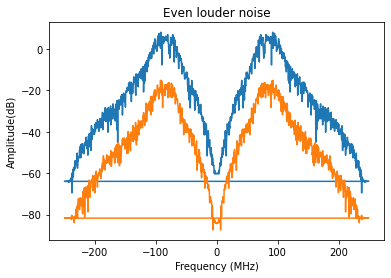

In [53]:
plt.plot(freqs_band_limited_noise, db(result_spectrum_louder[0]))
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum_louder, axis=0)))
plt.title('Even louder noise')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

Text(0, 0.5, 'Amplitude(dB)')

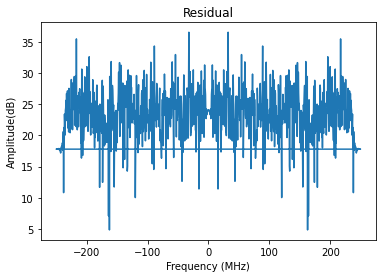

In [54]:
plt.plot(freqs_band_limited_noise, db(result_spectrum_louder[0])- db(np.mean(result_spectrum_louder, axis=0)))
plt.title('Residual')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

# compare the three results 

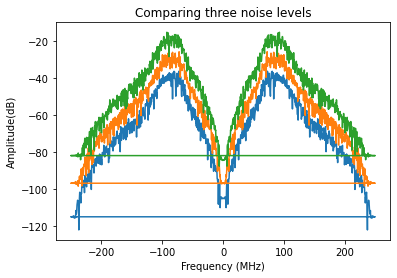

In [55]:
plt.title('Comparing three noise levels')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum_walsh, axis=0)))
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum_loud, axis=0)))
plt.plot(freqs_band_limited_noise, db(np.mean(result_spectrum_louder, axis=0)))

In [56]:
resid0 = db(result_spectrum_walsh[0])- db(np.mean(result_spectrum_walsh, axis=0))
resid1 = db(result_spectrum_loud[0])- db(np.mean(result_spectrum_loud, axis=0))
resid2 = db(result_spectrum_louder[0])- db(np.mean(result_spectrum_louder, axis=0))

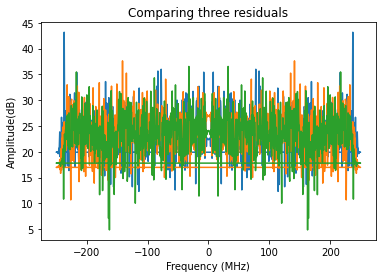

In [57]:
plt.title('Comparing three residuals')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')
plt.plot(freqs_band_limited_noise, resid0)
plt.plot(freqs_band_limited_noise, resid1)
plt.plot(freqs_band_limited_noise, resid2)

In [58]:
print(np.mean(resid0))
print(np.mean(resid1))
print(np.mean(resid2))

(23.469247697076483-0.01332398788889183j)
(23.406273173280468+6.164513344231182e-13j)
(23.244792983244395+1.0311751452718454e-11j)


## Does a CW signal do the same?

In [116]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
frequency = 75e6  # 75 MHz
sample_rate = 500e6  # 500 MHz
num_samples = 1024 * 32 * 100  # Number of samples (divisible by 1024 for FFT)

# Generate time array
t = np.arange(num_samples) / sample_rate

freqs_cw = (fftfreq(1024, 1 / sample_rate))/1e6
print(freqs_cw.shape)

# Generate sine wave
sine_wave = np.sin(2 * np.pi * frequency * t)

#add some noise
white_noise = np.random.normal(0, 10, len(t))

signal = sine_wave + white_noise 

(1024,)


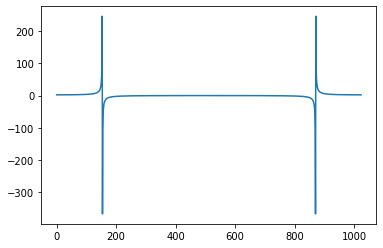

In [118]:
plt.plot(np.fft.fft(sine_wave,1024))

Text(0, 0.5, 'Amplitude(dB)')

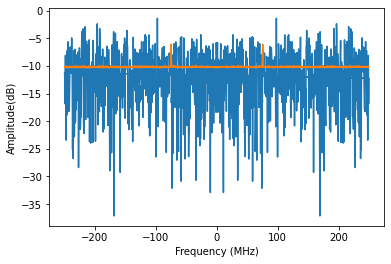

In [119]:
result_spectrum_cw = pfb_spectrometer(signal, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")
long_int = np.mean(result_spectrum_cw, axis=0)
plt.plot(freqs_cw, db(result_spectrum_cw[0]))
plt.plot(freqs_cw, db(long_int))            
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

In [120]:
period_base = len(t)//32
walshextended = np.zeros((2,len(t)))
print(walshextended.shape)
for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(walsh_matrix[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

(2, 3276800)


(1024,)


Text(0, 0.5, 'Amplitude(dB)')

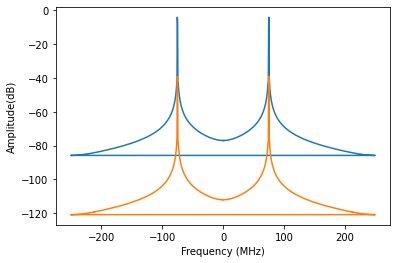

In [121]:
result_spectrum_cw_walsh = pfb_spectrometer_walsh(sine_wave, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")
print(result_spectrum_cw_walsh[0].shape)
long_int = np.mean(result_spectrum_cw_walsh, axis=0)
plt.plot(freqs_cw , db(result_spectrum_cw_walsh[0]))
plt.plot(freqs_cw , db(long_int))       
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

Text(0, 0.5, 'Amplitude(dB)')

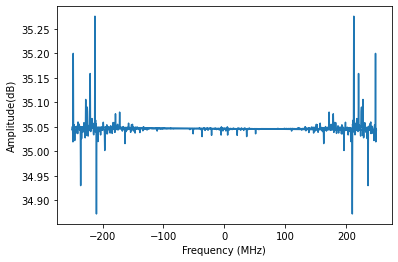

In [123]:
plt.plot(freqs_cw , db(result_spectrum_cw_walsh[0])-db(long_int))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

## amp up the amplitude

In [124]:
sine_wave = 100*np.sin(2 * np.pi * frequency * t)

Text(0, 0.5, 'Amplitude(dB)')

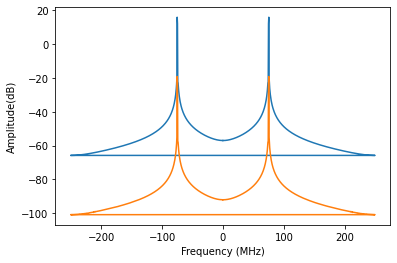

In [125]:
result_spectrum_cw_walsh = pfb_spectrometer_walsh(sine_wave, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")
long_int = np.mean(result_spectrum_cw_walsh, axis=0)
plt.plot(freqs_cw , db(result_spectrum_cw_walsh[0]))
plt.plot(freqs_cw , db(long_int)) 
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

Text(0, 0.5, 'Amplitude(dB)')

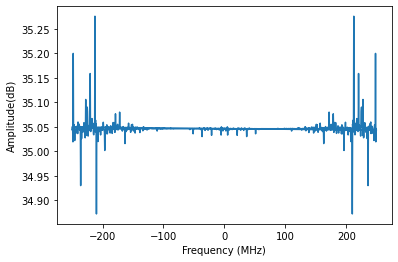

In [126]:
plt.plot(freqs_cw, db(result_spectrum_cw_walsh[0])-db(long_int))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude(dB)')

## Sweep across freq

In [150]:
# Define parameters
num_waves = 100

# Generate sine waves
frequencies = np.linspace(1e6, 241e6, num_waves)
sample_rate = 500e6  # 500 MHz
num_samples = 1024 * 32 * 100  # Number of samples (divisible by 1024 for FFT)

# Generate time array
t = np.arange(num_samples) / sample_rate

freqs_cw = (fftfreq(1024, 1 / sample_rate))/1e6

period_base = len(t)//32
walshextended = np.zeros((2,len(t)))
print(walshextended.shape)
for i in range(2):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(walsh_matrix[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

(2, 3276800)


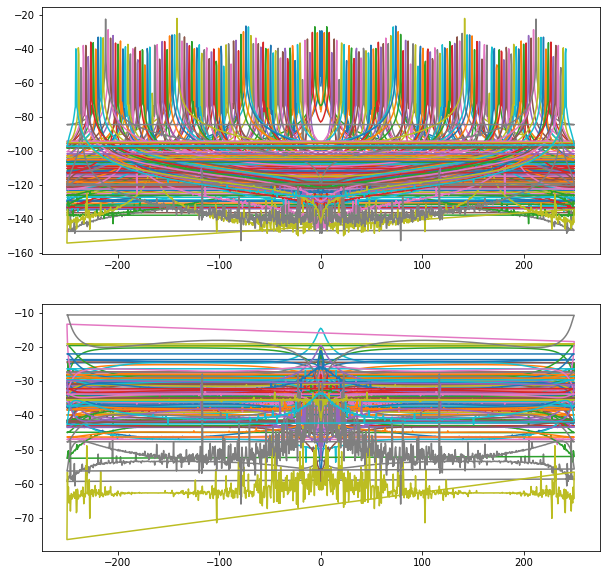

In [208]:
# Generate sine wave
resids = []
variances = []
fig, ax = plt.subplots(2, figsize=(10,10))
for i in range(len(frequencies)):
    sine_wave = np.sin(2 * np.pi * frequencies[i] * t)
    result_spectrum_cw_walsh = pfb_spectrometer_walsh(sine_wave, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")
    variance = np.var(result_spectrum_cw_walsh, axis=1)
    long_int = np.mean(result_spectrum_cw_walsh, axis=0)
    ax[0].plot(freqs_cw, db(long_int))
    ax[1].plot(freqs_cw, db(long_int)- db(result_spectrum_cw_walsh[0]))
    resid = abs(np.mean(long_int))
    varid = np.mean(variance)
    resids.append(resid)
    variances.append(varid)

211909090.9090909 141606060.60606062
107666666.66666667 73727272.72727273


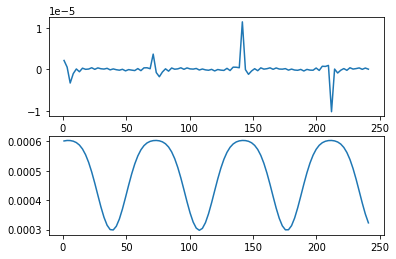

In [152]:
fig, ax = plt.subplots(2)
ax[0].plot(frequencies/1e6, resids)
ax[1].plot(frequencies/1e6, variances)
bestres = resids.index(min(resids))
worstres = resids.index(max(resids))
bestvar = variances.index(min(variances))
worstvar = variances.index(max(variances))
print(frequencies[bestres], frequencies[worstres])
print(frequencies[bestvar], frequencies[worstvar])

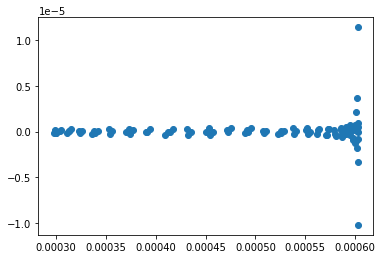

In [153]:
plt.scatter(variances, resids)

# Dependence on walsh function

In [159]:
def pfb_spectrometer_walsh(x, n_taps, n_chan, n_int, walshind1, walshind2, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    #apply walsh function 
    modulated = walshextended[walshind1]*x
    modulated2 = walshextended[walshind2]*x
    # Apply frontend, take FFT, then take power (i.e. square)
    
    x_fir1 = pfb_fir_frontend(modulated, win_coeffs, M, P)
    x_fir2 = pfb_fir_frontend(modulated2, win_coeffs, M, P)
    x_pfb = fft(x_fir1, P)
    x_pfb2 = np.conj(fft(x_fir2, P))
    x_psd = x_pfb*x_pfb2
    
    # Trim array so we can do time integration
    x_psd = x_pfb[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd


In [194]:
period_base = len(t)//32
walshextended = np.zeros((32,len(t)))
print(walshextended.shape)
for i in range(32):
    n= 0
    n2 = period_base
    for j in range(32):
        extended = np.array(walsh_matrix[i][j].repeat(period_base))
        walshextended[i][n:n2] = extended
        n += period_base
        n2 += period_base

def binary_to_gray(binary):
    gray = ""
    gray += binary[0]  # The first bit remains the same
    for i in range(1, len(binary)):
        # XOR operation between consecutive bits
        gray += str(int(binary[i-1]) ^ int(binary[i]))
    return gray

def count_ones_in_gray(gray_code):
    return gray_code.count('1')

ones = []

# Print binary, convert to Gray code, and count 1s
for i in range(17):
    binary_number = bin(i)[2:].zfill(5)  # Convert to binary, fill with leading zeros to ensure 5 bits
    gray_code = binary_to_gray(binary_number)
    ones_count = count_ones_in_gray(gray_code)
    if i ==0:
        ones.append(ones_count)
    elif i==16:
        ones.append(ones_count)
    else:
        ones.append(ones_count)
        ones.append(ones_count)
    print(f"Decimal: {i}, Binary: {binary_number}, Gray code: {gray_code}, Number of 1s: {ones_count}")

(32, 3276800)
Decimal: 0, Binary: 00000, Gray code: 00000, Number of 1s: 0
Decimal: 1, Binary: 00001, Gray code: 00001, Number of 1s: 1
Decimal: 2, Binary: 00010, Gray code: 00011, Number of 1s: 2
Decimal: 3, Binary: 00011, Gray code: 00010, Number of 1s: 1
Decimal: 4, Binary: 00100, Gray code: 00110, Number of 1s: 2
Decimal: 5, Binary: 00101, Gray code: 00111, Number of 1s: 3
Decimal: 6, Binary: 00110, Gray code: 00101, Number of 1s: 2
Decimal: 7, Binary: 00111, Gray code: 00100, Number of 1s: 1
Decimal: 8, Binary: 01000, Gray code: 01100, Number of 1s: 2
Decimal: 9, Binary: 01001, Gray code: 01101, Number of 1s: 3
Decimal: 10, Binary: 01010, Gray code: 01111, Number of 1s: 4
Decimal: 11, Binary: 01011, Gray code: 01110, Number of 1s: 3
Decimal: 12, Binary: 01100, Gray code: 01010, Number of 1s: 2
Decimal: 13, Binary: 01101, Gray code: 01011, Number of 1s: 3
Decimal: 14, Binary: 01110, Gray code: 01001, Number of 1s: 2
Decimal: 15, Binary: 01111, Gray code: 01000, Number of 1s: 1
Deci

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


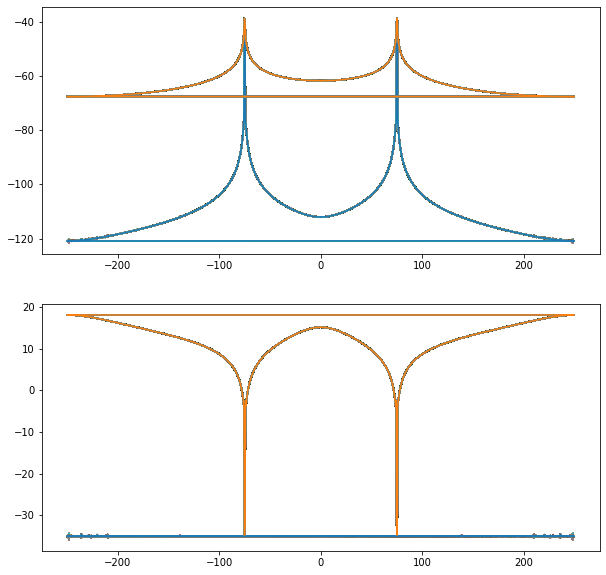

In [201]:
resids = np.zeros((32,32))
variances = np.zeros((32,32))
fig, ax = plt.subplots(2, figsize=(10,10))
sine_wave = np.sin(2 * np.pi * 75e6 * t)
for i in range((32)):
    for j in range((32)):
        if i==j:
            pass
        else:
            result_spectrum_cw_walsh = pfb_spectrometer_walsh(sine_wave, n_taps=M, n_chan=P, n_int=1, walshind1=i, walshind2=j, window_fn="hamming")
            variance = np.var(result_spectrum_cw_walsh, axis=1)
            long_int = np.mean(result_spectrum_cw_walsh, axis=0)
            ax[0].plot(freqs_cw, db(long_int))
            ax[1].plot(freqs_cw, db(long_int)- db(result_spectrum_cw_walsh[0]))
            resid = np.mean(long_int)
            varid = np.mean(variance)
            resids[i,j] = resid
            variances[i,j] = varid

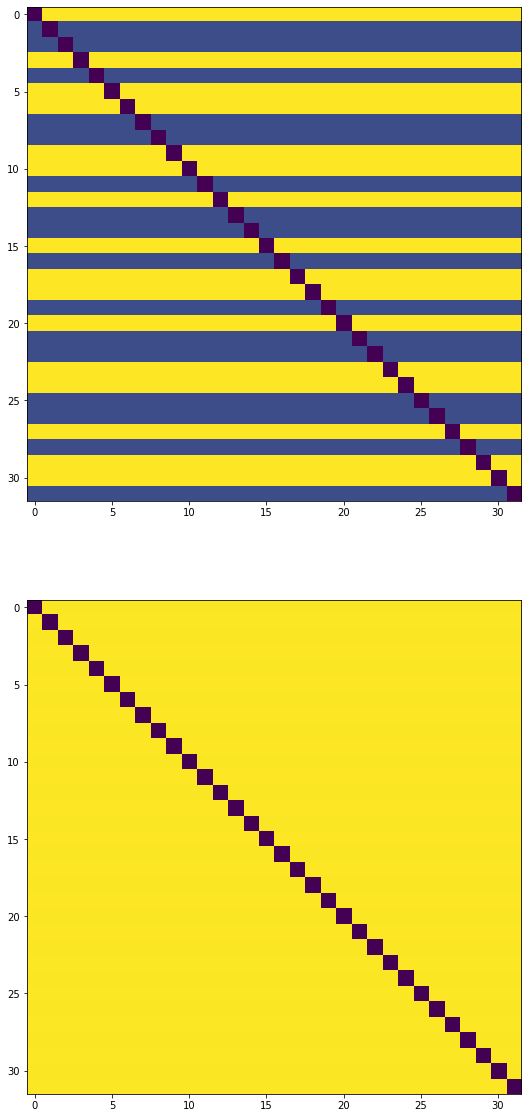

In [202]:
fig, ax = plt.subplots(2, figsize = (20,20))
ax[0].imshow(abs(resids))
ax[1].imshow(abs(variances))

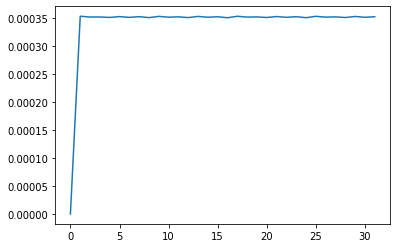

In [203]:
var = [item[0] for item in variances]
res = [item[0] for item in resids]
plt.plot(var)

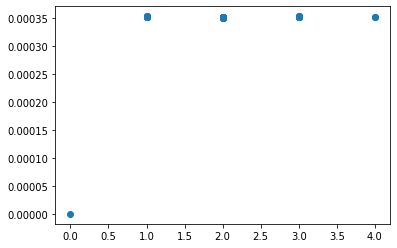

In [204]:
plt.scatter(ones,var)

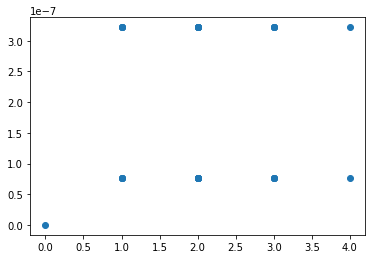

In [205]:
plt.scatter(ones,res)

# Check math in thesis

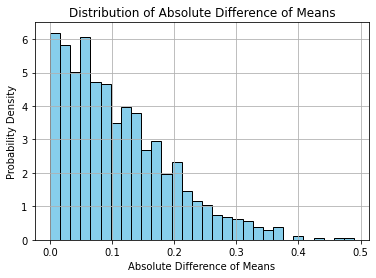

In [442]:
import numpy as np
import matplotlib.pyplot as plt

# Set parameters
num_trials = 1000
num_samples = 100
variance = 1  # Variance of the white noise

# Initialize array to store absolute differences of means
abs_diff_means = np.zeros(num_trials)

# Repeat the process for num_trials times
for i in range(num_trials):
    # Draw samples from white noise distribution
    samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
    
    # Calculate means of the two trials
    mean1 = np.mean(samples1)
    mean2 = np.mean(samples2)
    
    # Calculate absolute difference of means
    abs_diff_means[i] = np.abs(mean1 - mean2)

# Plot histogram of absolute differences of means
plt.hist(abs_diff_means, bins=30, density=True, color='skyblue', edgecolor='black')
plt.title('Distribution of Absolute Difference of Means')
plt.xlabel('Absolute Difference of Means')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

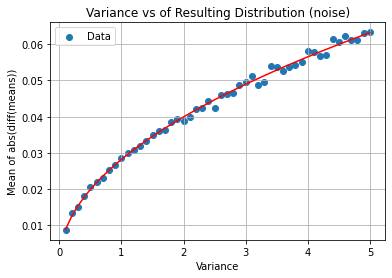

Parameters (a,b): [ 0.02835325 -0.00016453]


In [558]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.sqrt(x) + b

num_trials = 1000
num_samples = 1600
variance_values = np.linspace(0.1, 5, 50)  


mean_results = []

for variance in variance_values:
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        abs_diff_means[i] = np.abs(mean1 - mean2)

    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)

popt, pcov = curve_fit(func, variance_values, mean_results)

plt.scatter(variance_values, mean_results, label='Data')
plt.plot(variance_values, func(variance_values, *popt), 'r-')
plt.title('Variance vs of Resulting Distribution (noise)')
plt.xlabel('Variance')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters (a,b):", popt)

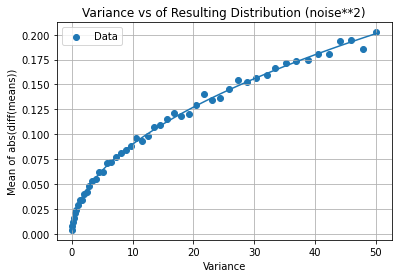

Parameters (a,b): [0.028396   0.00026694]
0.06266570686577501


In [559]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * np.sqrt(x) + b

# Set parameters
num_trials = 1000
num_samples = 1600
variance_values = np.linspace(0.1, 5, 50)  


mean_results = []
var_tot = []

for variance in variance_values:
    abs_diff_means = np.zeros(num_trials)
    variances = []
    for i in range(num_trials):
        
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples) ** 2
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples) ** 2
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        var1 = np.var(samples1)
        variances.append(var1)

        abs_diff_means[i] = np.abs(mean1 - mean2)

    var_tot.append(np.mean(variances))
    mean_resulting_distribution = np.mean(abs_diff_means)
    mean_results.append(mean_resulting_distribution)


popt, pcov = curve_fit(func, var_tot, mean_results)


plt.scatter(var_tot, mean_results, label='Data')
plt.plot(var_tot, func(var_tot, *popt))

plt.title('Variance vs of Resulting Distribution (noise**2)')
plt.xlabel('Variance')
plt.ylabel('Mean of abs(diff(means))')
plt.legend()
plt.grid(True)
plt.show()

print("Parameters (a,b):", popt)
print(1/(np.sqrt(num_samples/(2*np.pi))))

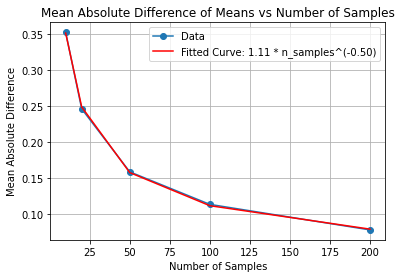

Parameters of the fitted curve (a, b): [ 1.10888954 -0.49853166]


In [565]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Function to calculate mean absolute difference of means
def mean_abs_diff(num_samples, num_trials, variance):
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        # Draw samples from white noise distribution
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        # Calculate absolute difference of means
        abs_diff_means[i] = np.abs(mean1 - mean2)
    
    # Calculate mean of the resulting distribution
    return np.mean(abs_diff_means)

# Define the function for fitting (power law)
def func(x, a, b):
    return a * np.power(x, b)

# Set parameters
num_trials = 1000
variance = 1  # Variance of the white noise
num_samples_list = [10, 20, 50, 100, 200]  # Different numbers of samples

# Calculate mean absolute difference for each number of samples
mean_abs_diff_list = []
for num_samples in num_samples_list:
    mean_abs_diff_list.append(mean_abs_diff(num_samples, num_trials, variance))

# Fit the curve to the data points
popt, pcov = curve_fit(func, num_samples_list, mean_abs_diff_list)

# Plot
plt.plot(num_samples_list, mean_abs_diff_list, marker='o', label='Data')
plt.plot(num_samples_list, func(num_samples_list, *popt), 'r-', label='Fitted Curve: {:.2f} * n_samples^({:.2f})'.format(*popt))
plt.title('Mean Absolute Difference of Means vs Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Mean Absolute Difference')
plt.legend()
plt.grid(True)
plt.show()

# Display the parameters of the fitted curve
print("Parameters of the fitted curve (a, b):", popt)

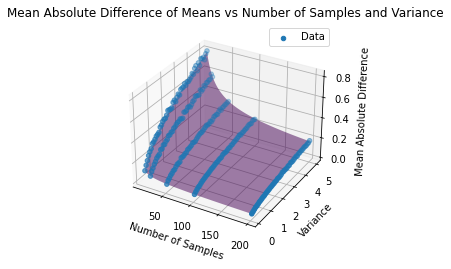

Parameters of the fitted curve (a, b, c): [ 1.10365345 -0.4942894   1.        ]


In [583]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit

# Function to calculate mean absolute difference of means
def mean_abs_diff(num_samples, num_trials, variance):
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        # Draw samples from white noise distribution
        samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
        samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
        
        # Calculate means of the two trials
        mean1 = np.mean(samples1)
        mean2 = np.mean(samples2)
        
        # Calculate absolute difference of means
        abs_diff_means[i] = np.abs(mean1 - mean2)
    
    # Calculate mean of the resulting distribution
    return np.mean(abs_diff_means)

# Define the function for fitting
def func(x, a, b, c):
    return a * np.power(x[:, 0], b)*np.sqrt(x[:, 1])

# Set parameters
num_trials = 1000
num_samples_list = np.array([10, 20, 50, 100, 200])  # Different numbers of samples
variance_values = np.linspace(0.1, 5, 50)  # Variance values to explore

# Create mesh grid for 3D plotting
num_samples_grid, variance_grid = np.meshgrid(num_samples_list, variance_values)

# Calculate mean absolute difference for each combination of num_samples and variance
mean_abs_diff_grid = np.zeros_like(num_samples_grid, dtype=float)
for i in range(num_samples_grid.shape[0]):
    for j in range(num_samples_grid.shape[1]):
        mean_abs_diff_grid[i, j] = mean_abs_diff(num_samples_grid[i, j], num_trials, variance_grid[i, j])

# Flatten the grids for curve fitting
num_samples_flat = num_samples_grid.flatten()
variance_flat = variance_grid.flatten()
mean_abs_diff_flat = mean_abs_diff_grid.flatten()

# Combine the independent variables into a single array
independent_vars = np.column_stack((num_samples_flat, variance_flat))

# Fit the curve to the data points
popt, pcov = curve_fit(func, independent_vars, mean_abs_diff_flat)

# Plot the fitted surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(num_samples_flat, variance_flat, mean_abs_diff_flat, marker='o', label='Data')
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Variance')
ax.set_zlabel('Mean Absolute Difference')
plt.title('Mean Absolute Difference of Means vs Number of Samples and Variance')

# Generate surface plot
X, Y = np.meshgrid(np.linspace(min(num_samples_list), max(num_samples_list), 100), np.linspace(min(variance_values), max(variance_values), 100))
Z = func(np.column_stack((X.flatten(), Y.flatten())), *popt).reshape(X.shape)
ax.plot_surface(X, Y, Z, alpha=0.5, rstride=100, cstride=100, cmap='viridis')

plt.legend()
plt.show()

# Display the parameters of the fitted curve
print("Parameters of the fitted curve (a, b, c):", popt)

## now, we should be able to calculate our Walsh residual for any noise 

In [612]:
a =  1.10365345
b = -0.5

# Set parameters
num_trials = 100000
num_samples = 1000
variance = 15  # Variance of the white noise

# Initialize array to store absolute differences of means
abs_diff_means = np.zeros(num_trials)
expected_means = np.zeros(num_trials)

# Repeat the process for num_trials times
for i in range(num_trials):
    # Draw samples from white noise distribution
    samples1 = np.random.normal(0, np.sqrt(variance), num_samples)
    samples2 = np.random.normal(0, np.sqrt(variance), num_samples)
    
    # Calculate means of the two trials
    mean1 = np.mean(samples1)
    mean2 = np.mean(samples2)
    
    # Calculate absolute difference of means
    abs_diff_means[i] = np.abs(mean1 - mean2)
    
    #calculate the expected value
    
expected_mean = a*np.power(num_samples,b)*np.sqrt(variance)

print(expected_mean)
print(np.mean(abs_diff_means))

0.13516939026811337
0.13843923481124348


### actually use the walsh function 


In [620]:
a =  1.10365345
b = -0.5

# Set parameters
num_trials = 100000
num_samples = 3200
variance = 15  # Variance of the white noise

# Initialize array to store absolute differences of means
abs_diff_means = np.zeros(num_trials)
expected_means = np.zeros(num_trials)

# Repeat the process for num_trials times
for i in range(num_trials):
    # Draw samples from white noise distribution
    samples1 = np.random.normal(1, np.sqrt(variance), num_samples)
    walshed = samples1*sorted_walsh[1]
    mean1 = np.mean(walshed[0:num_samples//2])
    mean2 = np.mean(walshed[num_samples//2:])
    abs_diff_means[i] = np.abs(mean1 + mean2)
    
    #calculate the expected value
    
expected_mean = a*np.power(num_samples//2,b)*np.sqrt(variance)

print(expected_mean)
print(np.mean(abs_diff_means))

0.106860785795859
0.10922880186509121


### try noise squared

In [624]:
a =  1.10365345
b = -0.5

# Set parameters
num_trials = 100000
num_samples = 3200
variance = 15  
varsquares = []
# Initialize array to store absolute differences of means
abs_diff_means = np.zeros(num_trials)
expected_means = np.zeros(num_trials)

# Repeat the process for num_trials times
for i in range(num_trials):
    # Draw samples from white noise distribution
    samples1 = np.random.normal(1, np.sqrt(variance), num_samples)**2
    varsquares.append(np.var(samples1))
    walshed = samples1*sorted_walsh[1]
    mean1 = np.mean(walshed[0:num_samples//2])
    mean2 = np.mean(walshed[num_samples//2:])
    abs_diff_means[i] = np.abs(mean1 + mean2)
    
    #calculate the expected value
squaredvar = np.mean(varsquares)   
expected_mean = a*np.power(num_samples//2,b)*np.sqrt(squaredvar)

print(expected_mean)
print(np.mean(abs_diff_means))

0.6230288666524065
0.6369517009396847


/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10
/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in subtract


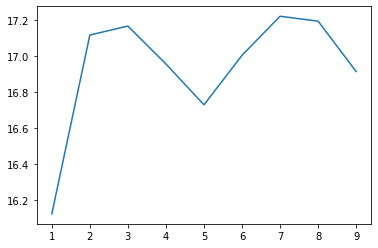

In [633]:
a =  1.10365345
b = -0.5

# Set parameters
num_trials = 100
num_samples = 3200
variance = 15  

amp = np.linspace(0,100000,10)
end_means = np.zeros(len(amp))
start_means = np.zeros(len(amp))
# Repeat the process for num_trials times
j=0
for amplitude in amp:
    varsquares = []
    meanmeans = []
# Initialize array to store absolute differences of means
    abs_diff_means = np.zeros(num_trials)
    for i in range(num_trials):
        # Draw samples from white noise distribution
        samples1 = (amplitude*np.random.normal(1, np.sqrt(variance), num_samples))**2
        meanmeans.append(2*np.mean(samples1))
        varsquares.append(np.var(samples1))
        walshed = samples1*sorted_walsh[1]
        mean1 = np.mean(walshed[0:num_samples//2])
        mean2 = np.mean(walshed[num_samples//2:])
        abs_diff_means[i] = np.abs(mean1 + mean2)
    
    #calculate the expected value
    squaredvar = np.mean(varsquares)   
    expected_mean = a*np.power(num_samples//2,b)*np.sqrt(squaredvar)
    start_means[j] = np.mean(meanmeans)
    end_means[j] = np.mean(abs_diff_means)
    j+=1

plt.plot(db(start_means)- db(end_means))